# F1 algorithm to predict the drivers in the podium and their positions

My name is Gabriela, and I follow F1 since I was around 10 years old. I am looking for an algorithm that helps me predict who will win the race several laps before it ends. This is a project in continuous progress as I am testing different algorithms to find the one that is closer to help me make my predictions

It is difficult, I know! :O
There are a lot of factors that influence who wins a race in F1. Some of them can be predicted easily but some of them cannot.

If you have a suggestion or an idea, please feel free to let me know ;)

In [1209]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://media.giphy.com/media/TgHQOqCqf9GH6/giphy.gif")

In [1210]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score #measures used to evaluate the models
from sklearn.metrics import confusion_matrix, classification_report #confusion matrix to evaluate results

from sklearn.model_selection import GridSearchCV #Hyperparameter optimization
from sklearn.model_selection import KFold #set kfold configuration
from sklearn.model_selection import cross_val_score #cross validation
from sklearn.metrics import make_scorer #set scores desired to train models
from sklearn.metrics import mean_squared_error

path = 'C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/F1/Data/'

np.random.seed(1994) #random seed

##  I. Importing data

In [1211]:
#The data stored in this path is obtained from the API of https://ergast.com/mrd/. It is continuously updated.
#To update this data please run the file "API_Requests_Results_Qualifying_Laps_PitStops.py"

ResultsDF=pd.read_csv(path+"ResultsDF.csv")
QualifyingDF=pd.read_csv(path+"QualifyingDF.csv")
LapsDF=pd.read_csv(path+"LapsDF.csv")

C:\Users\gabri\AppData\Local\Temp\ipykernel_24616\856236660.py:6: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  LapsDF=pd.read_csv(path+"LapsDF.csv")


Counting the number of features per dataframe

In [1212]:
ResultsDF=ResultsDF[ResultsDF["season"]>=2012].reset_index()
ResultsDF=ResultsDF.drop(columns=["index","Unnamed: 0"])
# ResultsDF.info() ##33

QualifyingDF=QualifyingDF[QualifyingDF["season"]>=2012].reset_index()
QualifyingDF=QualifyingDF.drop(columns=["index","Unnamed: 0"])
# QualifyingDF.info() #24

LapsDF=LapsDF[LapsDF["season"]>=2012].reset_index()
LapsDF=LapsDF.drop(columns=["index","Unnamed: 0"])
# LapsDF.info() #16

## II. Data Preprocessing (Part 1)

### Creating and transforming some features:

In [1213]:
#Creating Season-Round feature:
ResultsDF["Season-Round"]=ResultsDF["season"].astype(str)+"-"+ResultsDF["round"].astype(str)
LapsDF["Season-Round"]=LapsDF["season"].astype(str)+"-"+LapsDF["round"].astype(str)
QualifyingDF["Season-Round"]=QualifyingDF["season"].astype(str)+"-"+QualifyingDF["round"].astype(str)

#Creating Season-Round-Driver feature:
ResultsDF["Season-Round-DriverID"]=ResultsDF["season"].astype(str)+"-"+ResultsDF["round"].astype(str)+"-"+ResultsDF['Driver.driverId'].astype(str)
LapsDF["Season-Round-DriverID"]=LapsDF["season"].astype(str)+"-"+LapsDF["round"].astype(str)+"-"+LapsDF['driverId'].astype(str)
QualifyingDF["Season-Round-DriverID"]=QualifyingDF["season"].astype(str)+"-"+QualifyingDF["round"].astype(str)+"-"+QualifyingDF['Driver.driverId'].astype(str)

#Creating Season-Round-Lap feature:
LapsDF["Season-Round-DriverID-Lap"]=LapsDF["season"].astype(str)+"-"+LapsDF["round"].astype(str)+"-"+LapsDF['driverId'].astype(str)+"-"+LapsDF['LapNumber'].astype(str)

In [1214]:
def label_race(row):
    if row["status"]=='Finished':
        return "Completed"
    elif row["status"]=='+1 Lap':
        return "Completed"
    elif row["status"]=='+2 Laps':
        return "Completed"
    elif row["status"]=='+3 Laps':
        return "Completed"
    elif row["status"]=='+4 Laps':
        return "Completed"
    elif row["status"]=='+5 Laps':
        return "Completed"
    elif row["status"]=='+6 Laps':
        return "Completed"
    elif row["status"]=='+7 Laps':
        return "Completed"
    elif row["status"]=='+8 Laps':
        return "Completed"
    elif row["status"]=='+9 Laps':
        return "Completed"
    elif row["status"]=='+10 Laps':
        return "Completed"
    elif row["status"]=='+11 Laps':
        return "Completed"
    elif row["status"]=='+12 Laps':
        return "Completed"
    elif row["status"]=='+13 Laps':
        return "Completed"
    else:
        return "Not Completed"

def podium(row):
    if row["position"]==1:
        return "Podium"
    elif row["position"]==2:
        return "Podium"
    elif row["position"]==3:
        return "Podium"
    else:
        return "No Podium"

In [1215]:
ResultsDF["Completed"]=ResultsDF.apply (lambda row: label_race(row), axis=1)
#ResultsDF.groupby(["Completed"])["status"].count().head(40)
1084+1+231+37+6+2+1+2+2103

3467

In [1216]:
ResultsDF["Podium"]=ResultsDF.apply (lambda row: podium(row), axis=1)

In [1217]:
#Turning fastestlap into seconds:
ResultsDF[['FastestLap.Time.timeMIN', 'FastestLap.Time.timeSEC']]=ResultsDF['FastestLap.Time.time'].str.split(":", expand=True)
ResultsDF['FastestLap.Time.time_in_seconds']=ResultsDF['FastestLap.Time.timeMIN'].astype(float)*60+ResultsDF['FastestLap.Time.timeSEC'].astype(float)
ResultsDF=ResultsDF.drop(columns=['FastestLap.Time.timeMIN', 'FastestLap.Time.timeSEC'])

#Transforming lap_duration into seconds:
LapsDF[['lap_durationMIN', 'lap_durationSEC','nothing']]=LapsDF['LapDuration'].str.split(":", expand=True)
LapsDF['lap_duration_in_seconds']=LapsDF['lap_durationMIN'].astype(float)*60+LapsDF['lap_durationSEC'].astype(float)
LapsDF=LapsDF.drop(columns=['lap_durationMIN', 'lap_durationSEC','nothing'])

#Transforming Q1 into seconds:
QualifyingDF[["Q1Min","Q1Sec"]]=QualifyingDF["Q1"].str.split(":", expand=True)
QualifyingDF['Q1_in_seconds']=QualifyingDF['Q1Min'].astype(float)*60+QualifyingDF['Q1Sec'].astype(float)
QualifyingDF=QualifyingDF.drop(columns=["Q1Min","Q1Sec"])

#Transforming Q2 into seconds:
QualifyingDF[["Q2Min","Q2Sec"]]=QualifyingDF["Q2"].str.split(":", expand=True)
QualifyingDF['Q2_in_seconds']=QualifyingDF['Q2Min'].astype(float)*60+QualifyingDF['Q2Sec'].astype(float)
QualifyingDF=QualifyingDF.drop(columns=["Q2Min","Q2Sec"])

#Transforming Q3 into seconds:
QualifyingDF[["Q3Min","Q3Sec"]]=QualifyingDF["Q3"].str.split(":", expand=True)
QualifyingDF['Q3_in_seconds']=QualifyingDF['Q3Min'].astype(float)*60+QualifyingDF['Q3Sec'].astype(float)
QualifyingDF=QualifyingDF.drop(columns=["Q3Min","Q3Sec"])

In [1218]:
#Circuit, drivers and constructors are encoded

from sklearn.preprocessing import LabelEncoder

circuit_encoder = LabelEncoder()
circuit_encoder.fit(ResultsDF['Circuit.circuitId'])
circuit_values=circuit_encoder.transform(ResultsDF['Circuit.circuitId'])
ResultsDF['Circuit.circuitId_encoded']=circuit_values

constructor_encoder = LabelEncoder()
constructor_encoder.fit(ResultsDF['Constructor.constructorId'])
constructor_values=constructor_encoder.transform(ResultsDF['Constructor.constructorId'])
ResultsDF['Constructor.constructorId_encoded']=constructor_values

driver_encoder = LabelEncoder()
driver_encoder.fit(ResultsDF['Driver.driverId'])
driver_values=driver_encoder.transform(ResultsDF['Driver.driverId'])
ResultsDF['driverId_encoded']=driver_values

### Handling outliers

In [1219]:
WithOutliersR=["Time.millis","FastestLap.Time.time_in_seconds","FastestLap.AverageSpeed.speed"]
WithOutliersQ=['Q1_in_seconds', 'Q2_in_seconds', 'Q3_in_seconds']
WithOutliersL=['lap_duration_in_seconds']

#### 2021 Round 12 - Belgium Grand Prix

In [1220]:
#Getting rid of rows that have less than 30 laps, this means that the race was irregular
Races=LapsDF["Season-Round"].unique()

for i in Races:
    if len(LapsDF[LapsDF["Season-Round"]==i])<30:
        print(i," - ",len(LapsDF[LapsDF["Season-Round"]==i]))

#it is only a problem in one race

2021-12  -  20


In [1221]:
#Dropping this race from the 3 df
ResultsDF=ResultsDF[ResultsDF["Season-Round"] != "2021-12"].reset_index()
ResultsDF=ResultsDF.drop(columns=["index"])

LapsDF=LapsDF[LapsDF["Season-Round"] != "2021-12"].reset_index()
LapsDF=LapsDF.drop(columns=["index"])

QualifyingDF=QualifyingDF[QualifyingDF["Season-Round"] != "2021-12"].reset_index()
QualifyingDF=QualifyingDF.drop(columns=["index"])


#### In Results DF

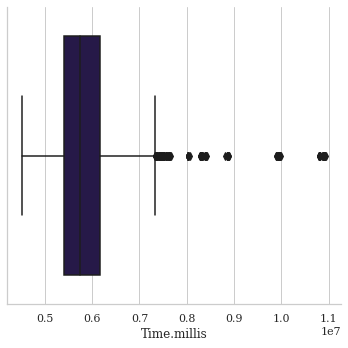

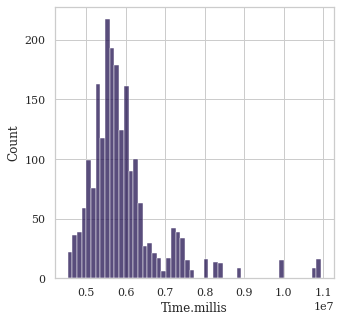

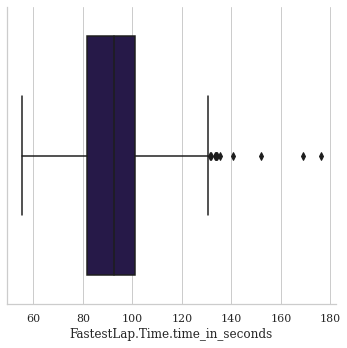

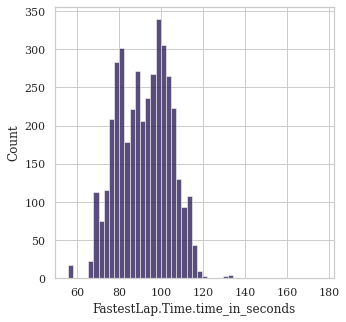

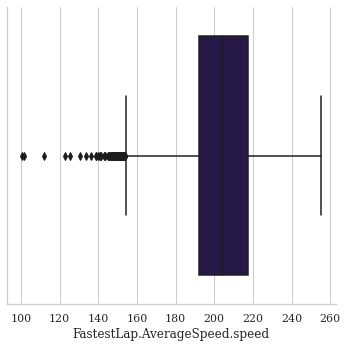

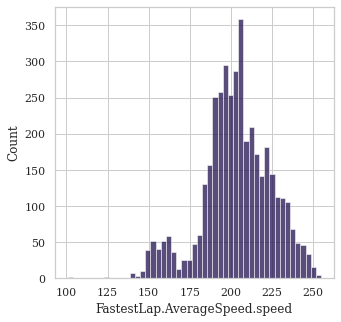

In [1222]:
for i in WithOutliersR:
    #Barplots
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    g=sns.catplot(x=i,data=ResultsDF,kind="box")
    g.set(xlabel=str(i))
    plt.show()
    
    #Histograms
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    fig, ax = plt.subplots(figsize=(5,5))
    sns.histplot(x=i,data=ResultsDF)
    plt.ylabel=str(i)
    plt.show()

In [1223]:
for i in WithOutliersR[:2]:
    #Quantile measures
    q1=ResultsDF[i].quantile(0.01)
    q99=ResultsDF[i].quantile(0.99)
 
    #TREATMENT FOR OUTLIERS: PERCENTILE BASED METHOD

    #Caps
    upper_extreme=q99
    lower_extreme=q1
 
    #Indexes that are above the limit
    Upper=ResultsDF[ResultsDF[i]>upper_extreme][i]
    Lower=ResultsDF[ResultsDF[i]<lower_extreme][i]
    print(str(i)," : ",str(len(Upper))," outliers.")

    # #Replacing outliers
    for n in Upper:
        ResultsDF[i]=ResultsDF[i].replace(n,upper_extreme)
    
    # for n in Lower:
    #     ResultsDF[i]=ResultsDF[i].replace(n,lower_extreme)
            
print("all done")

ii=WithOutliersR[-1]
#Quantile measures
q1=ResultsDF[ii].quantile(0.01)
q99=ResultsDF[ii].quantile(0.99)

#TREATMENT FOR OUTLIERS: PERCENTILE BASED METHOD

#Caps
upper_extreme=q99
lower_extreme=q1

#Indexes that are above the limit
Upper=ResultsDF[ResultsDF[ii]>upper_extreme][ii]
Lower=ResultsDF[ResultsDF[ii]<lower_extreme][ii]
print(str(ii)," : ",str(len(Lower))," outliers.")

# #Replacing outliers
for n in Lower:
    ResultsDF[i]=ResultsDF[i].replace(n,lower_extreme)

print("all done")

Time.millis  :  21  outliers.
FastestLap.Time.time_in_seconds  :  41  outliers.
all done
FastestLap.AverageSpeed.speed  :  41  outliers.
all done


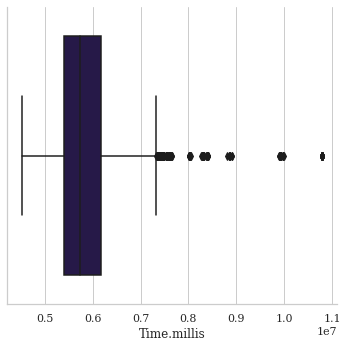

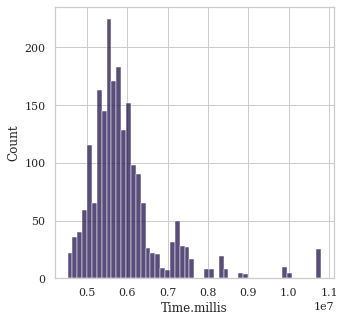

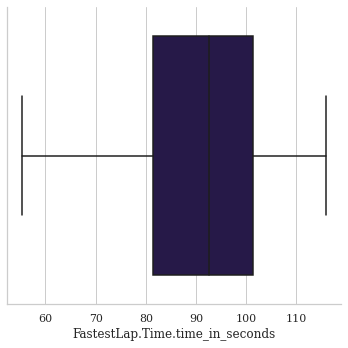

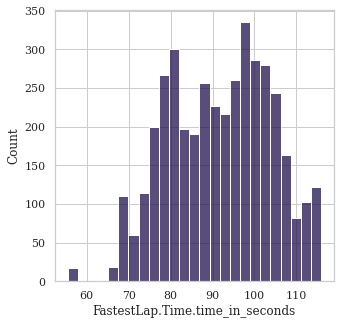

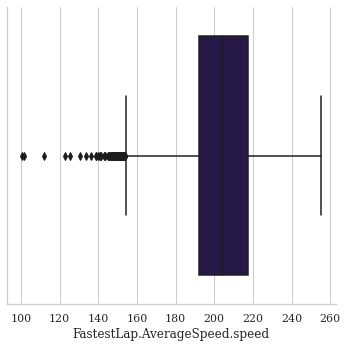

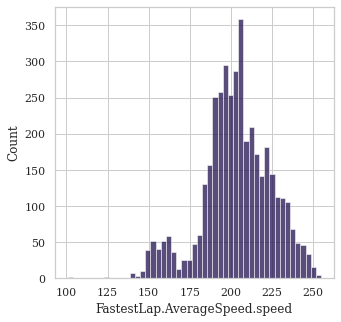

In [1224]:
for i in WithOutliersR:
    #Barplots
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    g=sns.catplot(x=i,data=ResultsDF,kind="box")
    g.set(xlabel=str(i))
    plt.show()
    
    #Histograms
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.histplot(x=i,data=ResultsDF)
    plt.ylabel=str(i)
    plt.show()

#### In Qualifying DF

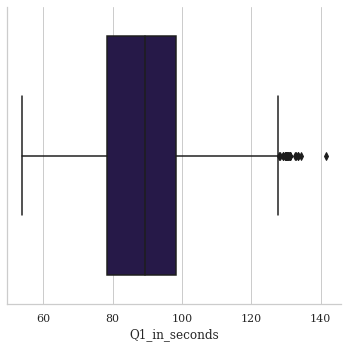

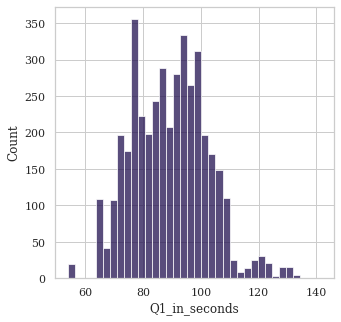

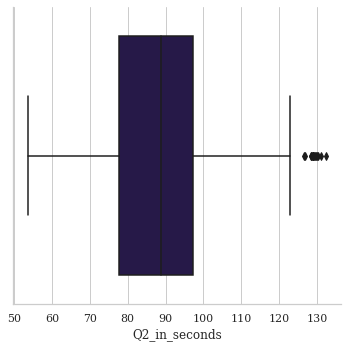

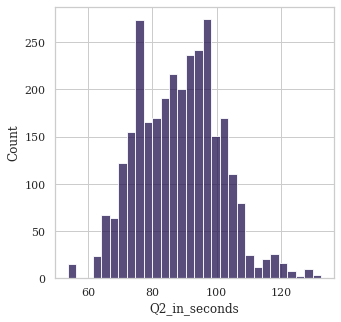

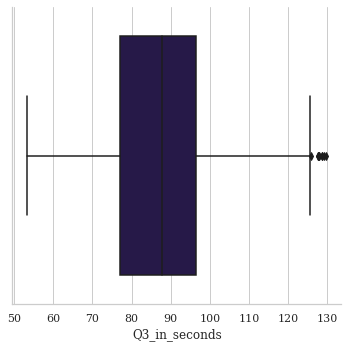

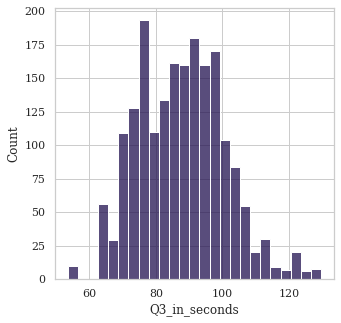

In [1225]:
for i in WithOutliersQ:
    #Barplots
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    g=sns.catplot(x=i,data=QualifyingDF,kind="box")
    g.set(xlabel=str(i))
    plt.show()
    
    #Histograms
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    fig, ax = plt.subplots(figsize=(5,5))
    sns.histplot(x=i,data=QualifyingDF)
    plt.ylabel=str(i)
    plt.show()

In [1226]:
for i in WithOutliersQ:
    #Quantile measures
    q1=QualifyingDF[i].quantile(0.01)
    q99=QualifyingDF[i].quantile(0.99)
 
    #TREATMENT FOR OUTLIERS: PERCENTILE BASED METHOD

    #Caps
    upper_extreme=q99
    lower_extreme=q1
 
    #Indexes that are above the limit
    Upper=QualifyingDF[QualifyingDF[i]>upper_extreme][i]
    Lower=QualifyingDF[QualifyingDF[i]<lower_extreme][i]
    print(str(i)," : ",str(len(Upper)+len(Lower))," outliers.")

    # #Replacing outliers
    for n in Upper:
        QualifyingDF[i]=QualifyingDF[i].replace(n,upper_extreme)
    
    # for n in Lower:
    #     QualifyingDF[i]=QualifyingDF[i].replace(n,lower_extreme)
            
print("all done")

Q1_in_seconds  :  84  outliers.
Q2_in_seconds  :  62  outliers.
Q3_in_seconds  :  40  outliers.
all done


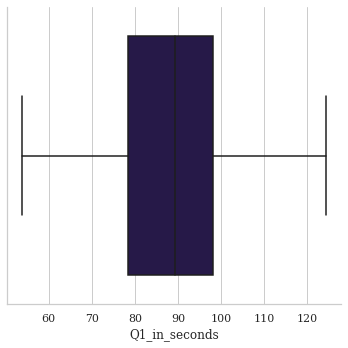

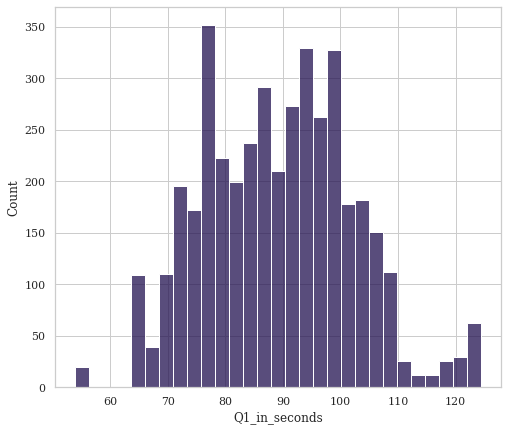

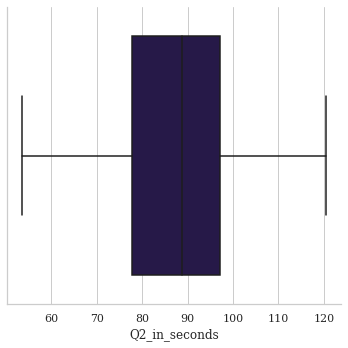

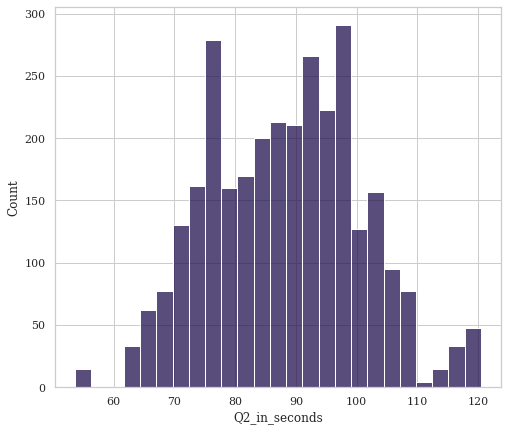

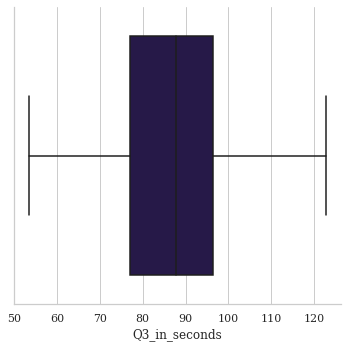

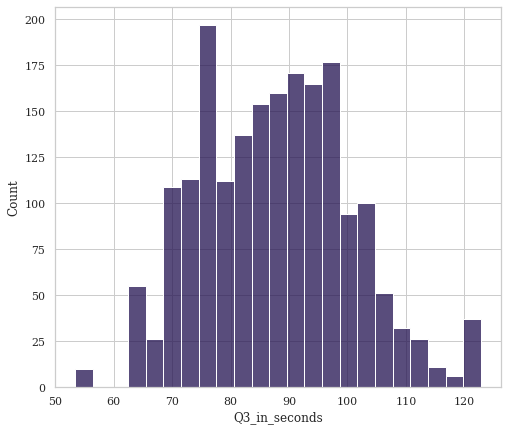

In [1227]:
for i in WithOutliersQ:
    #Barplots
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    g=sns.catplot(x=i,data=QualifyingDF,kind="box")
    g.set(xlabel=str(i))
    plt.show()
    
    #Histograms
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    fig, ax = plt.subplots(figsize=(8, 7))
    sns.histplot(x=i,data=QualifyingDF)
    plt.ylabel=str(i)
    plt.show()

#### In Laps DF

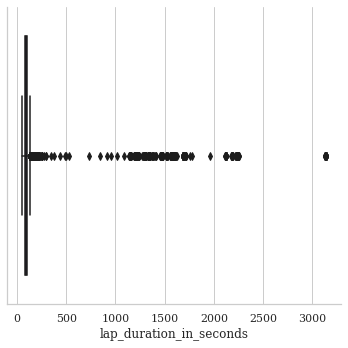

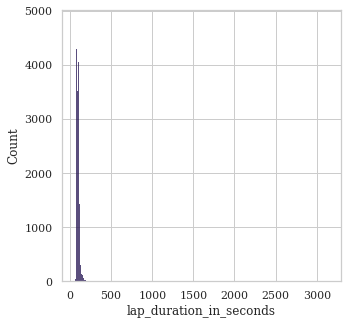

In [1228]:
for i in WithOutliersL:
    #Barplots
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    g=sns.catplot(x=i,data=LapsDF,kind="box")
    g.set(xlabel=str(i))
    plt.show()
    
    #Histograms
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    fig, ax = plt.subplots(figsize=(5,5))
    sns.histplot(x=i,data=LapsDF)
    plt.ylabel=str(i)
    plt.show()

In [1229]:
for i in WithOutliersL:
    #Quantile measures
    q1=LapsDF[i].quantile(0.01)
    q99=LapsDF[i].quantile(0.99)
 
    #TREATMENT FOR OUTLIERS: PERCENTILE BASED METHOD

    #Caps
    upper_extreme=q99
    lower_extreme=q1
 
    #Indexes that are above the limit
    Upper=LapsDF[LapsDF[i]>upper_extreme][i]
    Lower=LapsDF[LapsDF[i]<lower_extreme][i]
    print(str(i)," : ",str(len(Upper)+len(Lower))," outliers.")

    # #Replacing outliers
    for n in Upper:
        LapsDF[i]=LapsDF[i].replace(n,upper_extreme)
    
    # for n in Lower:
    #     LapsDF[i]=LapsDF[i].replace(n,lower_extreme)
            
print("all done")

lap_duration_in_seconds  :  4495  outliers.
all done


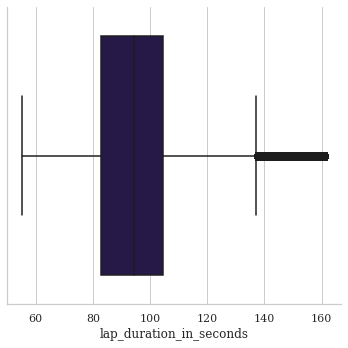

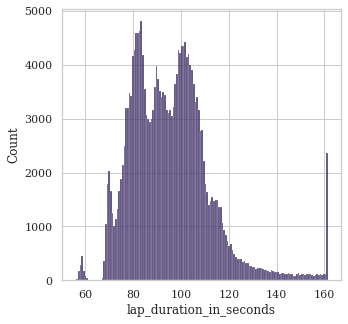

In [1230]:
for i in WithOutliersL:
    #Barplots
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    g=sns.catplot(x=i,data=LapsDF,kind="box")
    g.set(xlabel=str(i))
    plt.show()
    
    #Histograms
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    fig, ax = plt.subplots(figsize=(5,5))
    sns.histplot(x=i,data=LapsDF)
    plt.ylabel=str(i)
    plt.show()

### Handling Missing values

In [1231]:
#ResultsDF[(ResultsDF['Constructor.constructorId_encoded'].isna())&(ResultsDF["Completed"]=="Completed")]


In [1232]:
#Total time race (max value)
#Filling rows that dont have the prev race time to the max value posible, this becasue it is the longest we have seen that a car has finished a race.
#All the instances that have this value missing is becasue they did not end the race
ResultsDF['Time.millis'].fillna(ResultsDF['Time.millis'].max(),inplace=True)

#Fastest Lap Rank (max value)
# #Filling the rows with no prev rank with the max value posible, this becasue it is the lowest they can go. This happens when a pilot debuts, or they crashed in the first laps, if we put 0, the values can get messed up
# max because it is the worst they can do
ResultsDF['FastestLap.rank'].fillna(ResultsDF['FastestLap.rank'].max(),inplace=True)
ResultsDF['FastestLap.rank']=ResultsDF['FastestLap.rank'].replace(0,ResultsDF['FastestLap.rank'].max())
ResultsDF['FastestLap.rank'].unique()

#Fastest Lap Lap (0)
# #Filling the rows with 0 of the fastest lap. 0 Becasue it can give indicative that  if it it already passed the chance of being the fastest now it will be difficult
ResultsDF["FastestLap.lap"].fillna(0,inplace=True)

#Fastest Lap time (max value)
#Filling the value of the fastest lap with the max number available, this because if it did not have info, It possibly means that the race they did not had a fastest lap becasue they did not end the race 
ResultsDF["FastestLap.Time.time_in_seconds"].fillna(ResultsDF["FastestLap.Time.time_in_seconds"].max(),inplace=True)

#Fastest Lap Average Speed (min value)
#Filling the prev speed with the lowest speed possible
ResultsDF['FastestLap.AverageSpeed.speed'].fillna(ResultsDF['FastestLap.AverageSpeed.speed'].min(),inplace=True)


#Qualifying times (Q1,Q2,Q3) (max value)
# #Filling Q1 with max value posible+1 second
QualifyingDF["Q1_in_seconds"].fillna(QualifyingDF["Q1_in_seconds"].max(),inplace=True)

# #Filling Q2 with max value posible+1 second
QualifyingDF["Q2_in_seconds"].fillna(QualifyingDF["Q2_in_seconds"].max(),inplace=True)

# #Filling Q3 with max value posible+1 second
QualifyingDF["Q3_in_seconds"].fillna(QualifyingDF["Q3_in_seconds"].max(),inplace=True)


### Reducing the number of features present in ResultsDF

In [1233]:
#Adding some columns from ResultsDF to Laps_Pits

SelectedResults=ResultsDF[['Season-Round', 'Season-Round-DriverID',"Podium",'position','points', 'grid','laps', 'status', 'Driver.driverId','Driver.nationality',"Circuit.circuitId",
'Constructor.constructorId','Constructor.nationality','season', 'round',"Completed",'Time.millis','FastestLap.rank', 'FastestLap.lap', 'FastestLap.Time.time_in_seconds',
    'FastestLap.AverageSpeed.speed','driverId_encoded','Constructor.constructorId_encoded','Circuit.circuitId_encoded']]

#Renaming certain columns in SelectedResults
SelectedResults=SelectedResults.rename(columns={"position":'position_final_race',"laps":"laps_total_race","Driver.driverId":"driverId",'FastestLap.AverageSpeed.speed':'FastestLap.AverageSpeed.speedKph'})


### Joining Results + some summary information from Laps and Qualifying

#### Adding information from the past of ResultsDF

In [1234]:
#This dataframe is created to run the classiffier. We  wont include information of every single lap of the races but just the past of some laps.

#Modifying the structure of SelectedResults so that we can add some features with lags

WhereItWillBeChanged=SelectedResults["Season-Round"].unique()[1:] #Season where the info is included
TheLags=SelectedResults["Season-Round"].unique()[:-1] #Season where the info is extracted from

#Function to create the column with the lags. It generates a separate dataframe
def getThePrevious(name):
    #Just the information related to the final position of the race:
    SubsetSelectedResults=SelectedResults[['Season-Round-DriverID',"Season-Round","driverId",name]]
    NewName="Prev_"+name
    SubsetSelectedResults[NewName]=199408  #this is a random number that will not get confused with any other number to replace

    for i,race in enumerate(WhereItWillBeChanged):
        theDrivers=SelectedResults[SelectedResults["Season-Round"]==WhereItWillBeChanged[i]]["driverId"].unique()
        for d,driver in enumerate(theDrivers):
            Moving=SubsetSelectedResults[(SubsetSelectedResults["Season-Round"]==TheLags[i]) & (SubsetSelectedResults["driverId"]==theDrivers[d])][name].unique()
            if Moving.size==0: #In the case that we cannot find the value of the previous race for the driver for any reason
                continue
            else:
                theMove=SubsetSelectedResults[(SubsetSelectedResults["Season-Round"]==WhereItWillBeChanged[i]) & (SubsetSelectedResults["driverId"]==theDrivers[d])].replace(199408,Moving[0])
                SubsetSelectedResults[(SubsetSelectedResults["Season-Round"]==WhereItWillBeChanged[i]) & (SubsetSelectedResults["driverId"]==theDrivers[d])]=theMove
    UpdatedSubsetSelectedResults=SubsetSelectedResults.replace(199408,0) #In the cases of the extremes we need to make this adjustment

    return UpdatedSubsetSelectedResults

In [1235]:
# #Creating the lags in the different features

# PrevFinalPositions=getThePrevious("position_final_race")
# print("Ready: position_final_race")

# PrevGrid=getThePrevious("grid")
# print("Ready: Grid")

# PrevTimeMillis=getThePrevious('Time.millis')
# print("Ready: TimeMillis")

# PrevFastestLapRank=getThePrevious('FastestLap.rank')
# print("Ready: FastestLap.rank")

# PrevFastestLapLap=getThePrevious('FastestLap.lap')
# print("Ready: FastestLap.lap")

# PrevFastestLaptime_in_seconds=getThePrevious('FastestLap.Time.time_in_seconds')
# print("Ready: FastestLap.Time.time_in_seconds")

# PrevFastestLapAverageSpeedspeedKph=getThePrevious('FastestLap.AverageSpeed.speedKph')
# print("Ready: FastestLap.AverageSpeed.speedKph")

# PrevStatus=getThePrevious('status')
# print("Ready: Status")

In [1236]:
#The features extracted previously are added in SelectedResults:

PreSelectedResults=SelectedResults.copy(deep=True) #Making a dopy of the original df

SelectedResults=pd.merge(SelectedResults,PrevFinalPositions[["Season-Round-DriverID","Prev_position_final_race"]],on="Season-Round-DriverID",how="left")
SelectedResults=pd.merge(SelectedResults,PrevGrid[["Season-Round-DriverID","Prev_grid"]],on="Season-Round-DriverID",how="left")
SelectedResults=pd.merge(SelectedResults,PrevTimeMillis[["Season-Round-DriverID","Prev_Time.millis"]],on="Season-Round-DriverID",how="left")
SelectedResults=pd.merge(SelectedResults,PrevFastestLapRank[["Season-Round-DriverID","Prev_FastestLap.rank"]],on="Season-Round-DriverID",how="left")
SelectedResults=pd.merge(SelectedResults,PrevFastestLapLap[["Season-Round-DriverID","Prev_FastestLap.lap"]],on="Season-Round-DriverID",how="left")
SelectedResults=pd.merge(SelectedResults,PrevFastestLaptime_in_seconds[["Season-Round-DriverID","Prev_FastestLap.Time.time_in_seconds"]],on="Season-Round-DriverID",how="left")
SelectedResults=pd.merge(SelectedResults,PrevFastestLapAverageSpeedspeedKph[["Season-Round-DriverID","Prev_FastestLap.AverageSpeed.speedKph"]],on="Season-Round-DriverID",how="left")
SelectedResults=pd.merge(SelectedResults,PrevStatus[["Season-Round-DriverID","Prev_status"]],on="Season-Round-DriverID",how="left")


SelectedResults=SelectedResults.drop_duplicates()
SelectedResults=SelectedResults.reset_index()
SelectedResults=SelectedResults.drop(columns=["index"])

In [1237]:
# PreSelectedResults.info() #4245 entries, 0 to 4244
# SelectedResults[SelectedResults["driverId"]=="vettel"][['Season-Round-DriverID','position_final_race','Prev_position_final_race','grid', 'Prev_grid','Time.millis', 'Prev_Time.millis',
#        'FastestLap.rank','Prev_FastestLap.rank', 'FastestLap.lap','Prev_FastestLap.lap',
#        'FastestLap.Time.time_in_seconds','Prev_FastestLap.Time.time_in_seconds',
#        'FastestLap.AverageSpeed.speedKph','Prev_FastestLap.AverageSpeed.speedKph']].tail(6)


#### Adding information from QualifyingDF

In [1238]:
SelectedResults=pd.merge(SelectedResults,QualifyingDF[['Season-Round-DriverID','Q1_in_seconds', 'Q2_in_seconds', 'Q3_in_seconds']],on='Season-Round-DriverID',how="left")
len(SelectedResults)

4205

In [1239]:
# #Filling Q1 with max value posible+1 second
SelectedResults["Q1_in_seconds"].fillna(SelectedResults["Q1_in_seconds"].max(),inplace=True)

# #Filling Q2 with max value posible+1 second
SelectedResults["Q2_in_seconds"].fillna(SelectedResults["Q2_in_seconds"].max(),inplace=True)

# #Filling Q3 with max value posible+1 second
SelectedResults["Q3_in_seconds"].fillna(SelectedResults["Q3_in_seconds"].max(),inplace=True)


#### Adding information from the laps DF (function)

In [1240]:
#Function to create dataframe ResultsExpanded according to percentile chosen:

#it has basic information from the ResultsDF + information about specific laps from LapsDF

def createResultsExpanded(percentile,previous_laps_considered):
    #Copy of laps dataframe
    MLaps=LapsDF[LapsDF["season"]>=2012].copy(deep=True)

    #Selecting the maximum number of laps per race and season that we want to have available before making a prediction
    a=SelectedResults[SelectedResults["Completed"]=="Completed"][["season","round","laps_total_race"]].copy(deep=True)
    a["laps_considered"]=a["laps_total_race"]*percentile
    a["laps_considered"]=a["laps_considered"].astype(int)
    a=pd.DataFrame({'laps_considered' : a.groupby(["season","round",])["laps_considered"].max()}).reset_index()
    a

    #Selecting the laps that get inside this range
    MLaps=pd.merge(MLaps,a,on=["season","round"],how="left")
    SelectedLaps=MLaps[MLaps['LapNumber'] <= MLaps['laps_considered']] #only the ones equal or before

    #Fastest per driver and per race until that moment
    fastestperdriver=pd.DataFrame({'Fastest_per_driver' : SelectedLaps.groupby(["season","round","driverId"])["lap_duration_in_seconds"].min()}).reset_index()
    fastestperrace=pd.DataFrame({'Fastest_per_race' : SelectedLaps.groupby(["season","round"])["lap_duration_in_seconds"].min()}).reset_index()
    new=pd.merge(fastestperdriver,fastestperrace,on=["season","round"],how="left")
    new=pd.merge(new,a,on=["season","round"],how="left") #adding lap until it is being considered

    #Adding the previous laps and positions we want
    for i in range(1,previous_laps_considered+1):
        lapname='lap_'+str(i)+'_duration_secs'
        positionname='position_'+str(i)
        Lap_m=MLaps[["season","round","driverId","lap_duration_in_seconds","position"]][MLaps['LapNumber'] == (MLaps['laps_considered']-i)]
        new=pd.merge(new,Lap_m,on=["season","round","driverId"],how="left") #adding lap and position
        new=new.rename(columns={"lap_duration_in_seconds":lapname,"position":positionname})

    ResultsExpanded=pd.merge(SelectedResults,new,on=["season","round","driverId"],how="left")
    #ResultsExpanded = ResultsExpanded.dropna() #droping rows with na's

    ResultsExpanded=ResultsExpanded[ResultsExpanded["Completed"]=="Completed"].reset_index() #only the finished
    ResultsExpanded=ResultsExpanded.drop(columns=["index"])

    return ResultsExpanded

In [1241]:
#SelectedResults.info() #4205 entries, 0 to 4224
#SelectedResults[SelectedResults["Completed"]=="Completed"].reset_index().info() #RangeIndex: 3430 entries, 0 to 3429

## III. Premliminar EDA

#### A. How fast are the cars now?

##### The fastest lap per round (race) from season 2012 to 2022 per driver

In this graph we can see the fastest lap, per race, per driver, and per season. As from 2012 until the present, there have been a lot of drivers racing in F1, the legend show as the nationality of the driver. The label at the bottom of each point from each year also show us the name of the driver who did had the fastest lap of the season.

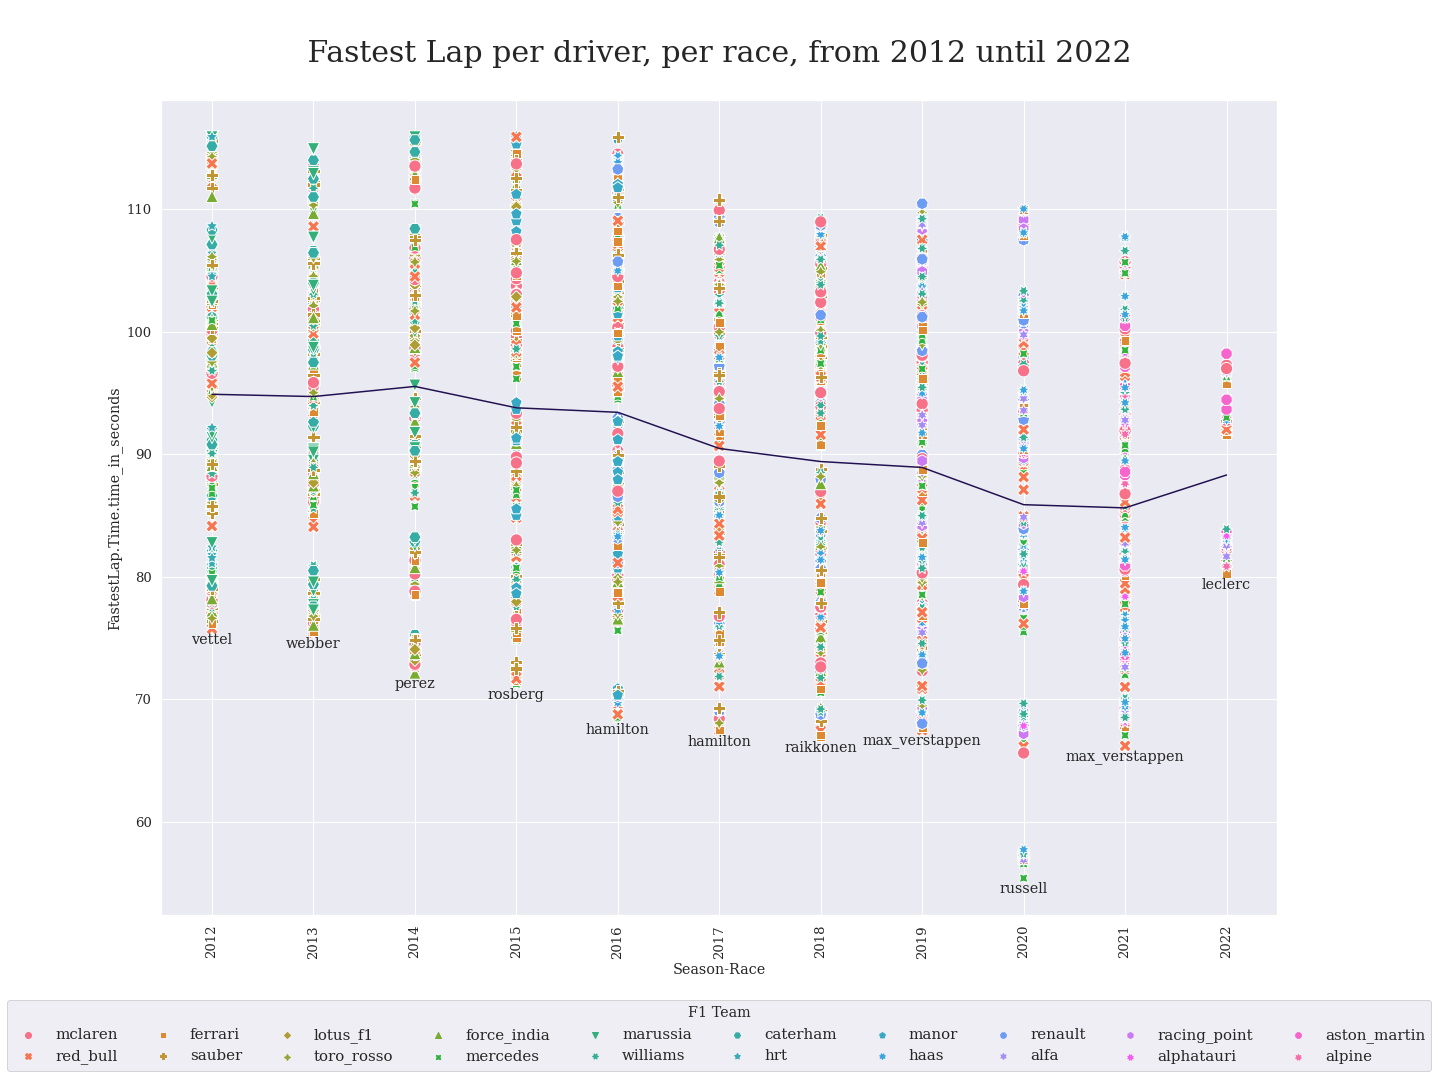

In [1242]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
Years=ResultsDF["season"].unique().tolist() #or seasons for plot

#Fastest lap per driver per season
LABELS=pd.DataFrame(columns=["Driver.driverId","FastestLap.Time.time_in_seconds","season"])
for i in ResultsDF[ResultsDF["season"]>=2012]["season"].unique().tolist():
    A=pd.DataFrame(ResultsDF[ResultsDF["season"]==i].groupby(["Driver.driverId"])["FastestLap.Time.time_in_seconds"].min())
    A["season"]=i
    Selected=A[A["FastestLap.Time.time_in_seconds"]==min(A["FastestLap.Time.time_in_seconds"])].reset_index()
    LABELS=pd.concat([LABELS,Selected])

#Plot
fig, ax = plt.subplots(figsize=(20, 15))
sns.scatterplot(x="season", y="FastestLap.Time.time_in_seconds",s=150,style='Constructor.constructorId',hue='Constructor.constructorId',ci=None,estimator="min",
           data=ResultsDF[ResultsDF["Completed"]=="Completed"])
sns.lineplot(x="season", y="FastestLap.Time.time_in_seconds",estimator="mean",ci=None,
           data=ResultsDF[ResultsDF["Completed"]=="Completed"])

plt.locator_params(axis="x", nbins = len(Years))
plt.title("\n Fastest Lap per driver, per race, from 2012 until 2022 \n",fontsize=30)
plt.xlabel("Season-Race")
# plt.ylabel("Fastest Lap in Seconds")
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(0.5, -0.2),loc='lower center', title="F1 Team", ncol=10,prop={'size': 15})


#Individual labels of the fastest lap of the season:
for label,y,x in LABELS.to_numpy():
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


plt.show()



##### Top speed per round from 2014 until 2022 per driver

This plot shows the top speed per race, per driver, per season. It also contains the team of each driver. Hamilton has been the fastest for 7 seasons with Mercedes! It is important to mention that the speed in which cars go depend on the mechanical regulations that the FIA has for each year. We would think that overtime, cars should get faster. Well, that doesn't happen because teams are obliged to satisfy safety and racing mechanical regulations per year.

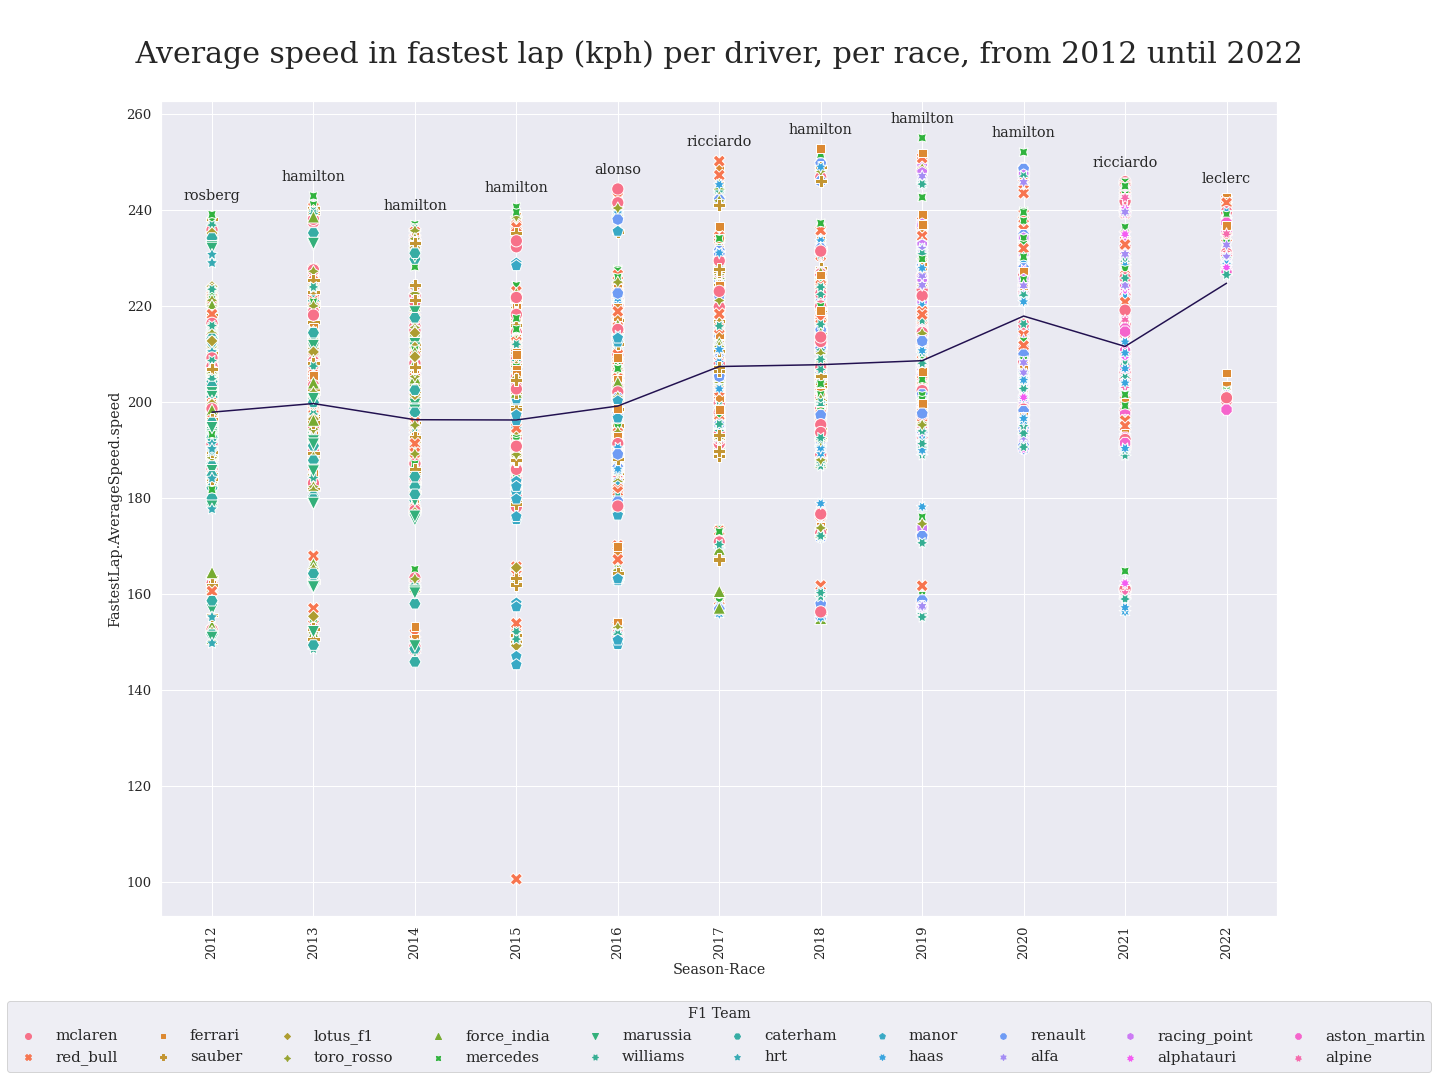

In [1243]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
Years=ResultsDF["season"].unique().tolist() #or seasons for plot

#Top speed per driver per season
LABELS=pd.DataFrame(columns=["Driver.driverId",'FastestLap.AverageSpeed.speed',"season"])
for i in ResultsDF[ResultsDF["season"]>=2012]["season"].unique().tolist():
    A=pd.DataFrame(ResultsDF[ResultsDF["season"]==i].groupby(["Driver.driverId"])['FastestLap.AverageSpeed.speed'].max())
    A["season"]=i
    Selected=A[A['FastestLap.AverageSpeed.speed']==max(A['FastestLap.AverageSpeed.speed'])].reset_index()
    LABELS=pd.concat([LABELS,Selected])

#Plot
fig, ax = plt.subplots(figsize=(20,15))
sns.scatterplot(x="season", y='FastestLap.AverageSpeed.speed',s=150,style='Constructor.constructorId',hue='Constructor.constructorId',ci=None,estimator="max",
           data=ResultsDF[ResultsDF["Completed"]=="Completed"])
sns.lineplot(x="season", y='FastestLap.AverageSpeed.speed',estimator="mean",ci=None,
           data=ResultsDF[ResultsDF["Completed"]=="Completed"])

plt.locator_params(axis="x", nbins = len(Years))
plt.title("\n Average speed in fastest lap (kph) per driver, per race, from 2012 until 2022 \n",fontsize=30)
plt.xlabel("Season-Race")
# plt.ylabel("Top speed (kph)")
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(0.5, -0.2),loc='lower center', title="F1 Team", ncol=10,prop={'size': 15})


#Individual labels of the fastest lap of the season:
for label,y,x in LABELS.to_numpy():
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


plt.show()


##### Top speed (kph) comparison per team in the last 10 years

In the last 10 years, the F1 has been dominated by Mercedes and Red Bull. This can be seen in the top speed of their cars. In seasons 2011, 2012, and 2013, Red Bull had the highest average top speeds during the season. However, from 2014 and later, this place was taken by Mercedes (except 2017 where Ferrari took the lead).

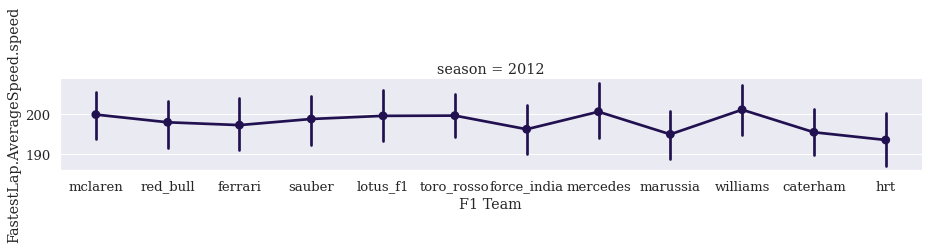

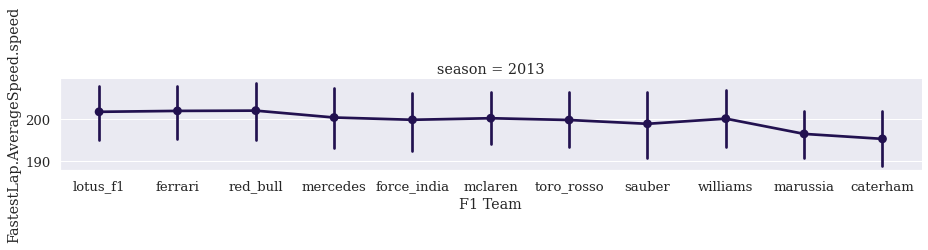

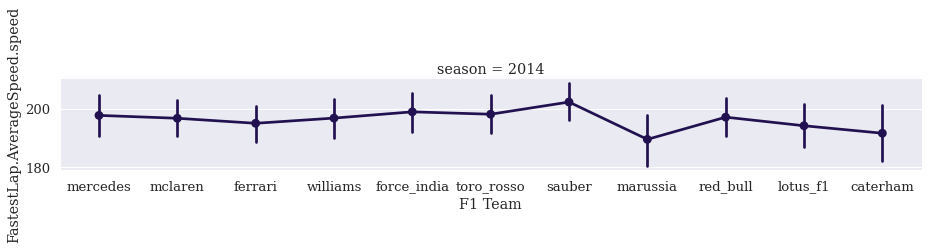

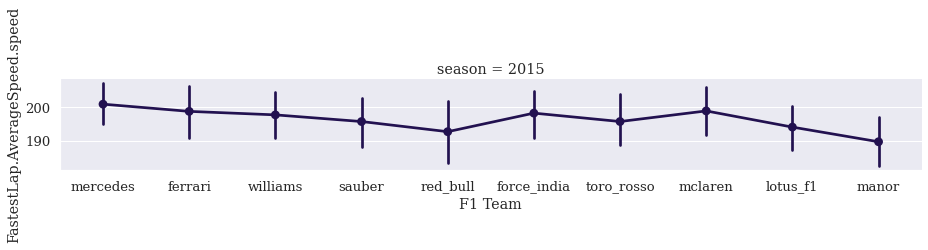

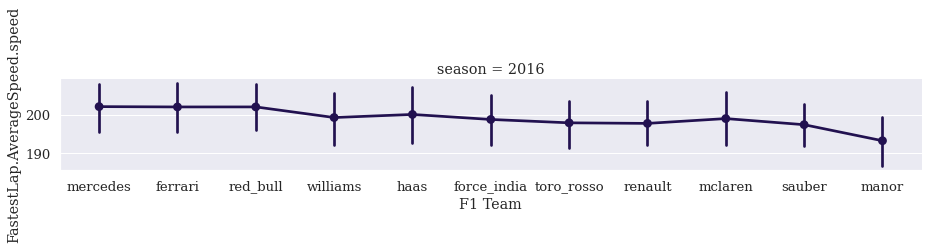

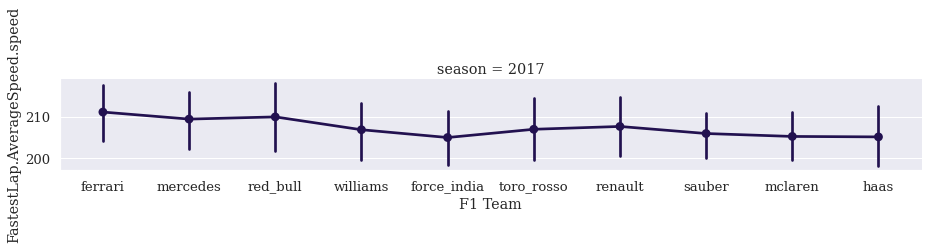

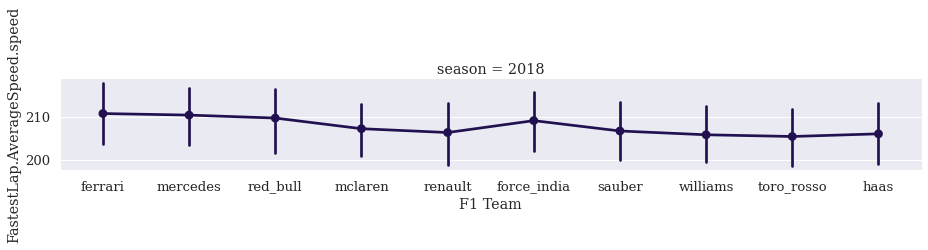

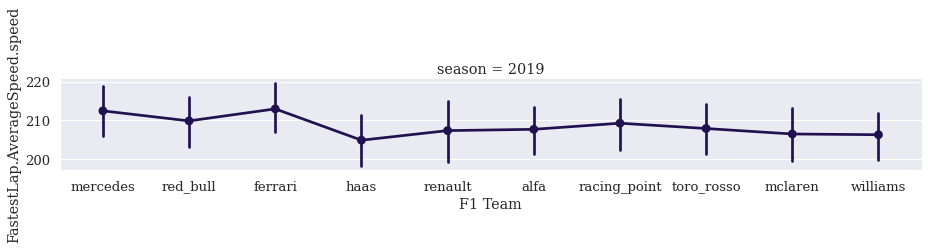

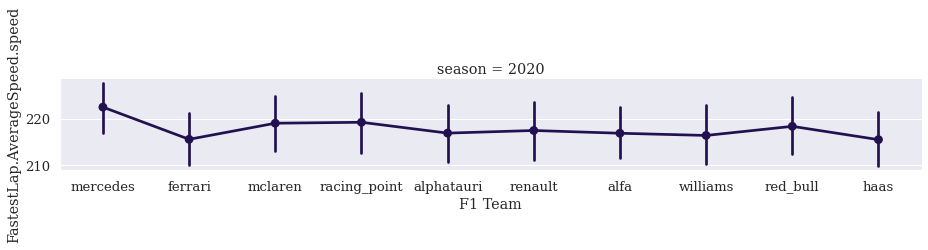

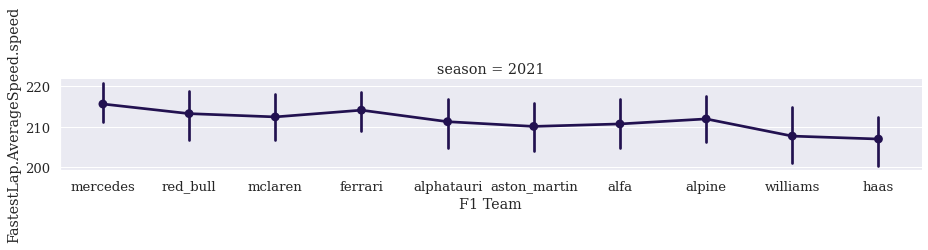

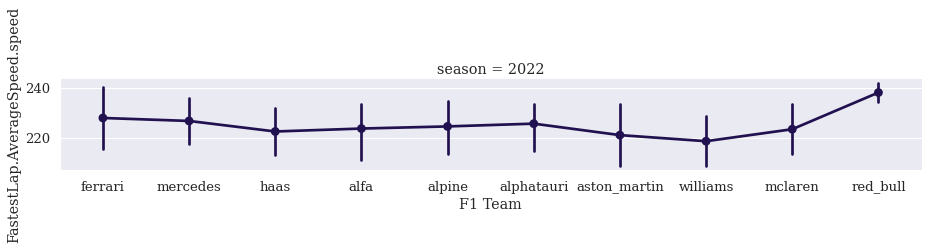

In [1244]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")


#Plot
for i in Years:
    if i<=2010:
        continue
    else:
        g = sns.catplot(x='Constructor.constructorId', y='FastestLap.AverageSpeed.speed',
        col="season",kind="point",col_wrap=3,height=2.5,aspect=5,
                data=ResultsDF[(ResultsDF["season"]==i)&(ResultsDF["Completed"]=="Completed")])
        plt.xlabel("F1 Team")
        # plt.ylabel("Top Speed (kmh)")

plt.show()


##### Fastest lap comparison between circuits (2021)

This analysis was done using last 2021 as reference. The fastest circuit in 2021 was the Red Bull Ring and the slowest, Baku.

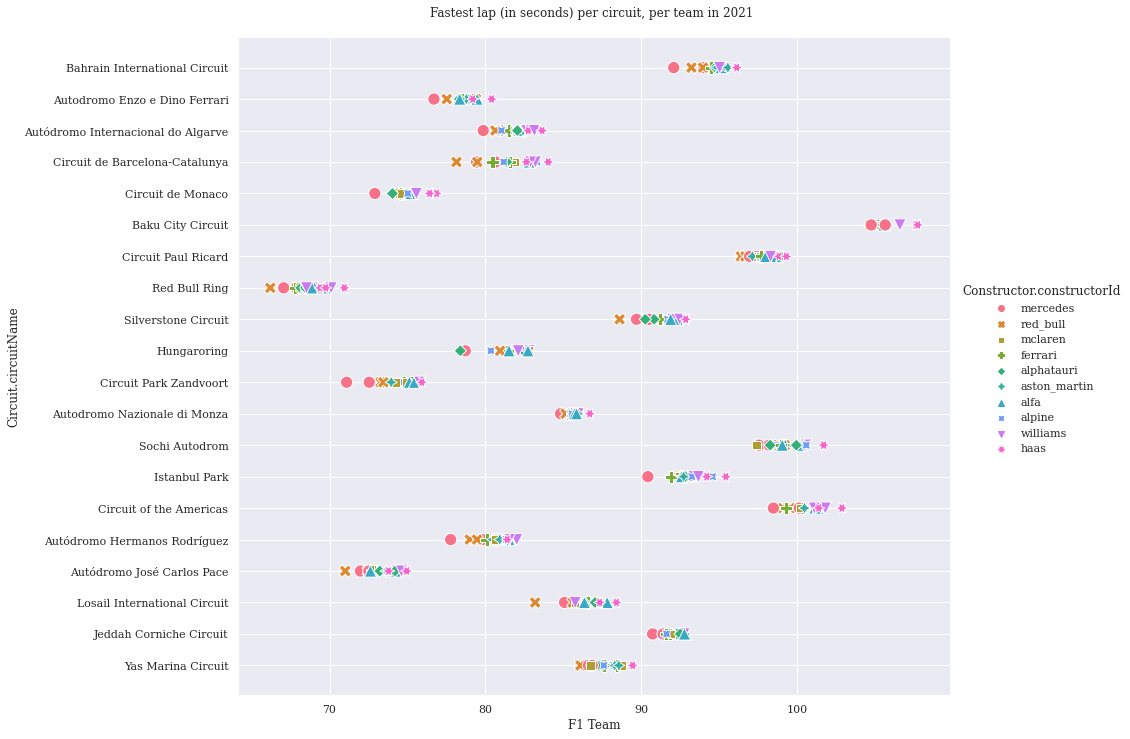

In [1245]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1,font="serif")

g = sns.relplot(x="FastestLap.Time.time_in_seconds", y='Circuit.circuitName',hue='Constructor.constructorId',height=10,aspect=1.4,
        style='Constructor.constructorId',s=150,data=ResultsDF[(ResultsDF["season"]==2021) & (ResultsDF["Completed"]=="Completed")])
plt.title("Fastest lap (in seconds) per circuit, per team in 2021 \n")
plt.xlabel("F1 Team")
# plt.ylabel("Fastest lap in seconds")


plt.show()


##### Time of entire race comparisson

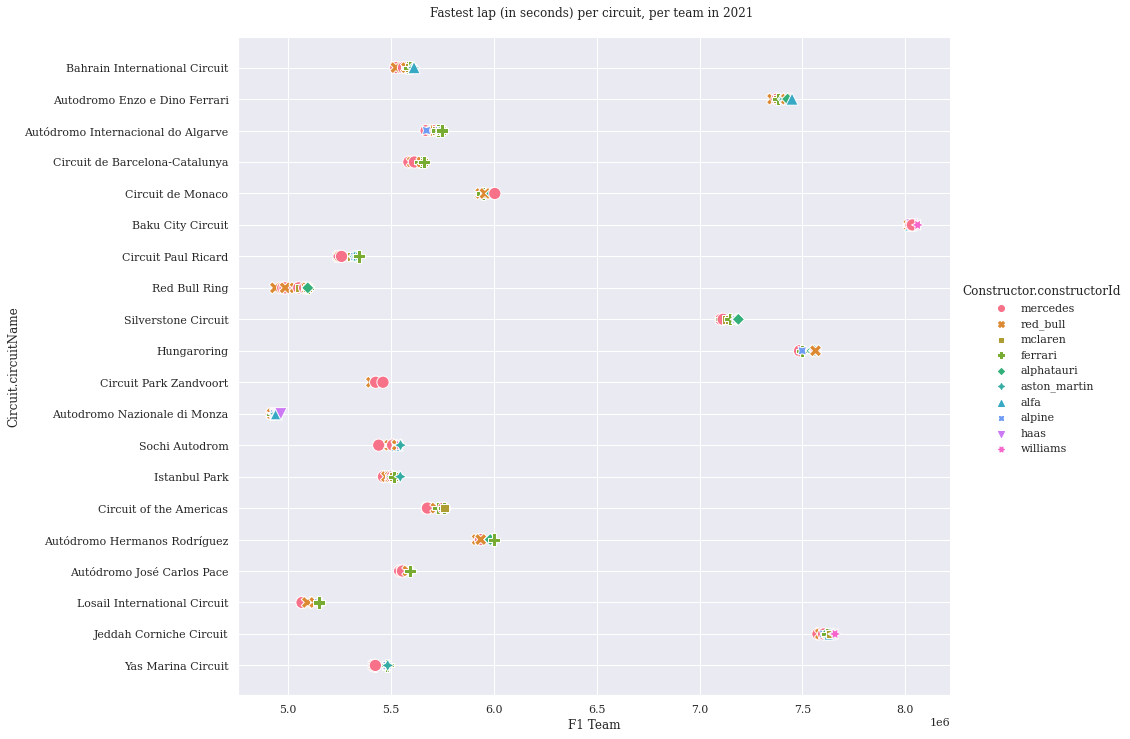

In [1246]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1,font="serif")

g = sns.relplot(x="Time.millis", y='Circuit.circuitName',hue='Constructor.constructorId',height=10,aspect=1.4,
        style='Constructor.constructorId',s=150,data=ResultsDF[(ResultsDF["season"]==2021) & (ResultsDF["status"]=="Finished")])
plt.title("Fastest lap (in seconds) per circuit, per team in 2021 \n")
plt.xlabel("F1 Team")
# plt.ylabel("Fastest lap in seconds")


plt.show()

#### B. Number of wins and points and other statistics for drivers and teams

In [1247]:
#Datasets created for the analysis
PositionsPerDriver=pd.DataFrame({'Number' : ResultsDF[ResultsDF['position']<=3].groupby(['position',"Driver.driverId","season"])['position'].count()}).reset_index()
PositionsPerTeam=pd.DataFrame({'Number' : ResultsDF[ResultsDF['position']<=3].groupby(['position','Constructor.constructorId',"season"])['position'].count()}).reset_index()
GridPerDriver=pd.DataFrame({'Number' : ResultsDF[(ResultsDF['grid']==1) | (ResultsDF['grid']==2)].groupby(['grid',"Driver.driverId","season"])['position'].count()}).reset_index()
GridPerTeam=pd.DataFrame({'Number' : ResultsDF[(ResultsDF['grid']==1) | (ResultsDF['grid']==2)].groupby(['grid','Constructor.constructorId',"season"])['position'].count()}).reset_index()


##### Final positions in the podium per driver (2017-2021)

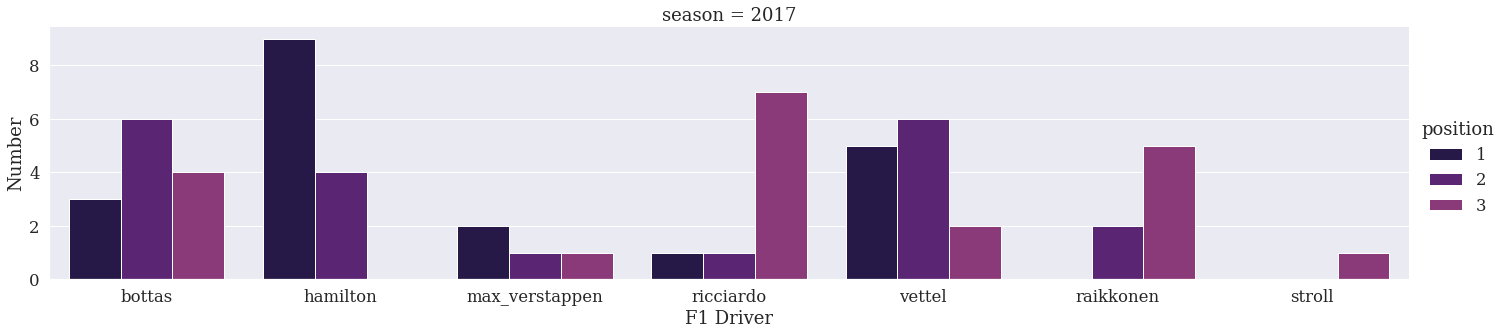

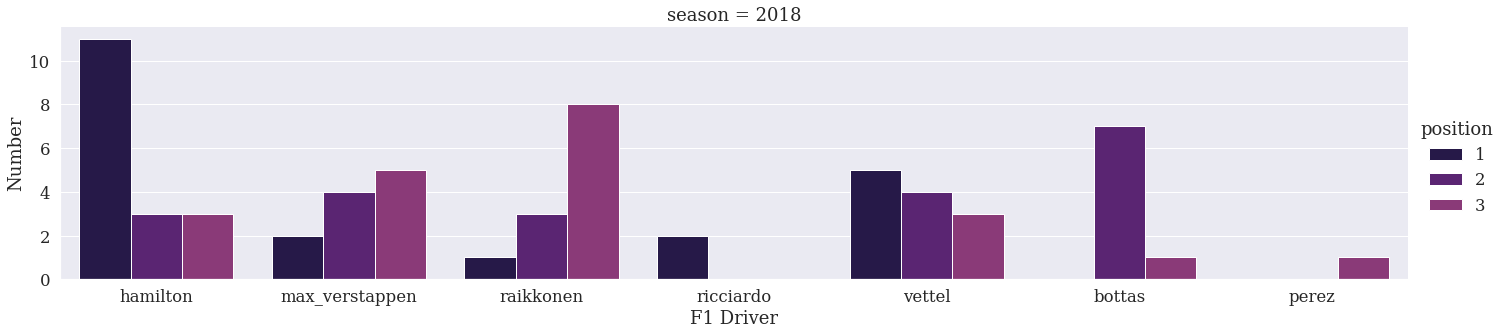

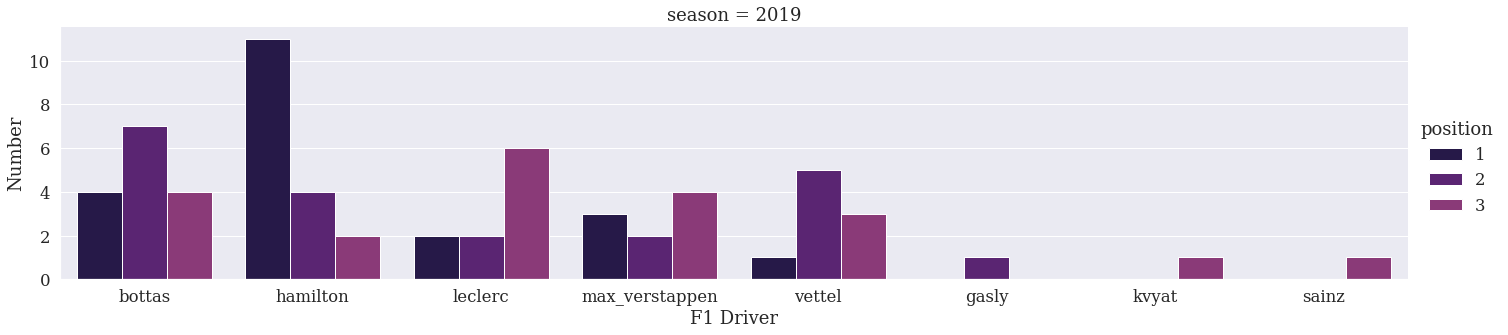

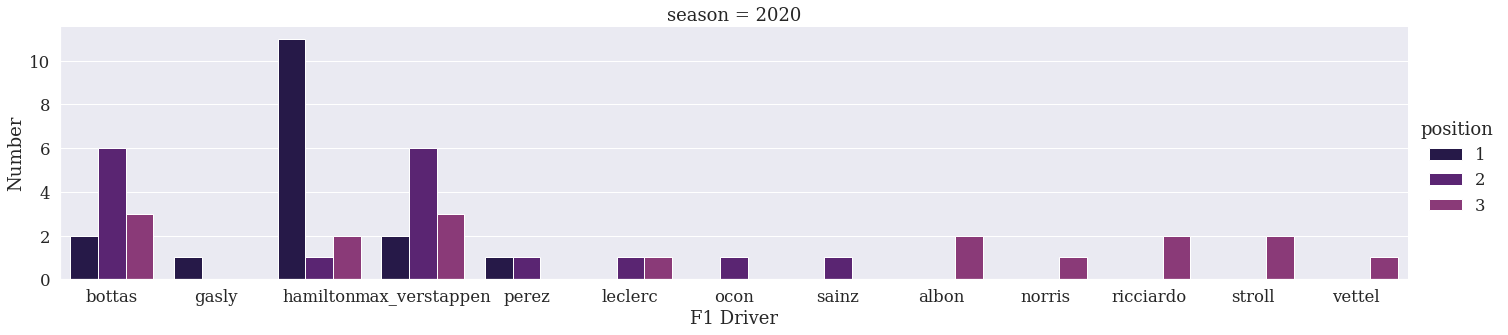

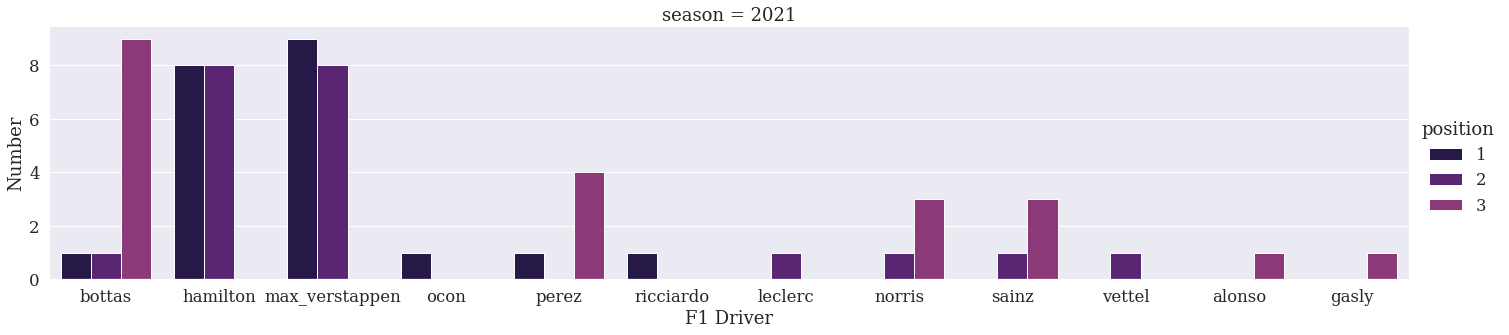

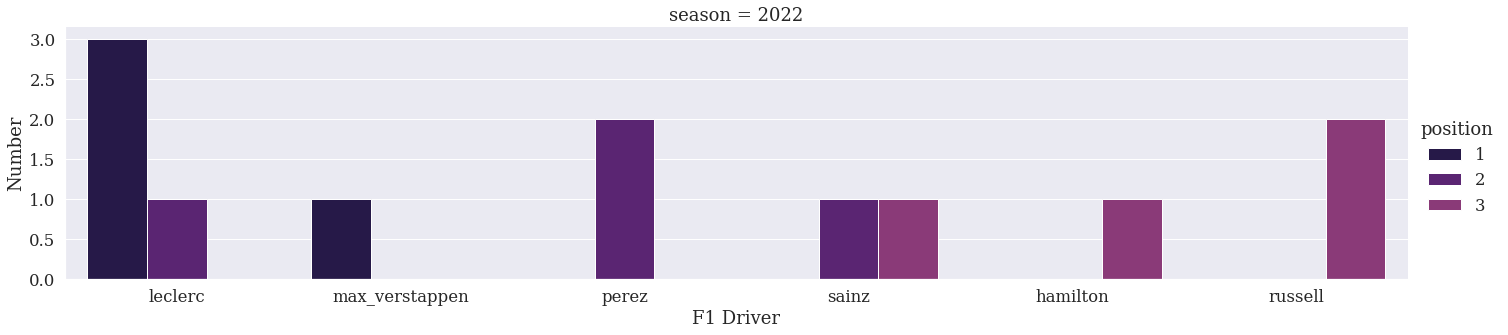

In [1248]:
#Ending in top 3 and counting how many times in each position per driver
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.5,font="serif")

#Plot
for i in Years:
    if i<=2016:
        continue
    else:
        g = sns.catplot(x='Driver.driverId',y="Number", col="season",kind="bar",height=5,aspect=4,hue="position",
            data=PositionsPerDriver[PositionsPerDriver["season"]==i])
        plt.xlabel("F1 Driver")
        #plt.ylabel("Times")

plt.show()

##### Final positions in the podium per team (2017-2021)

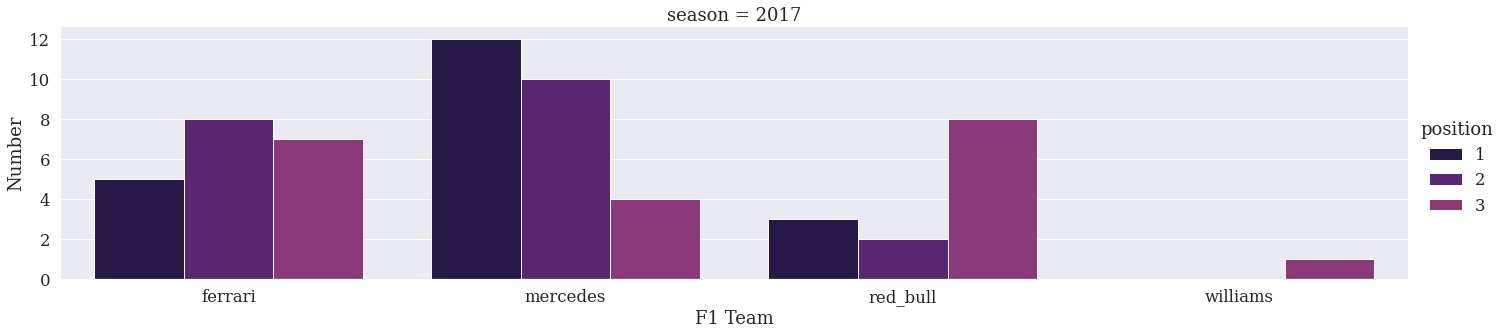

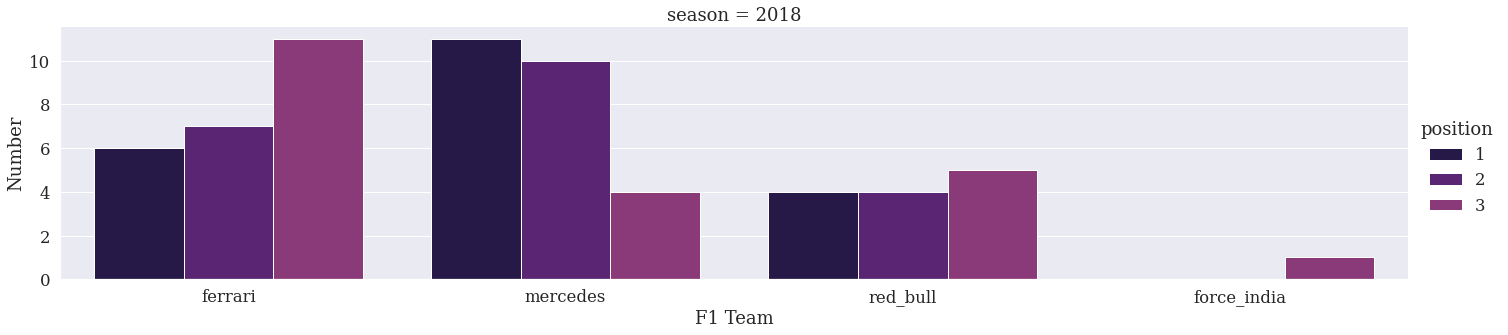

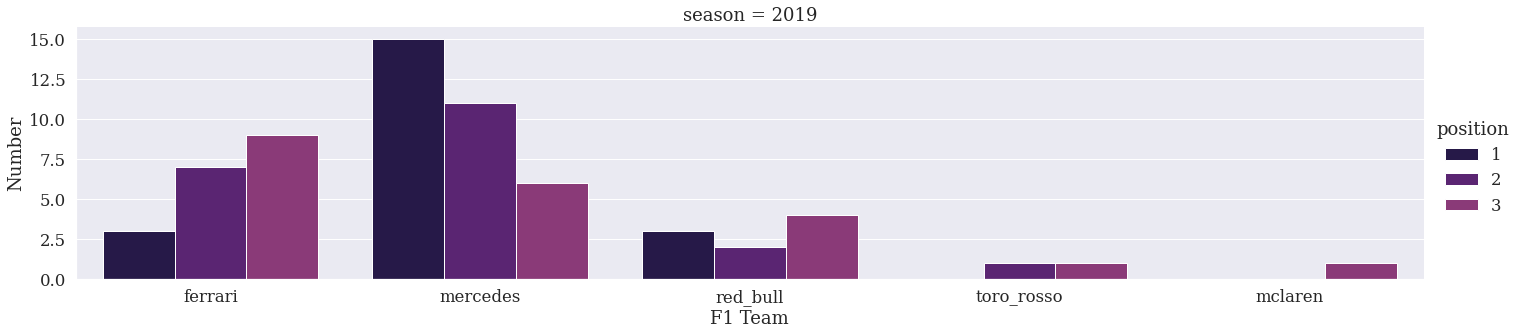

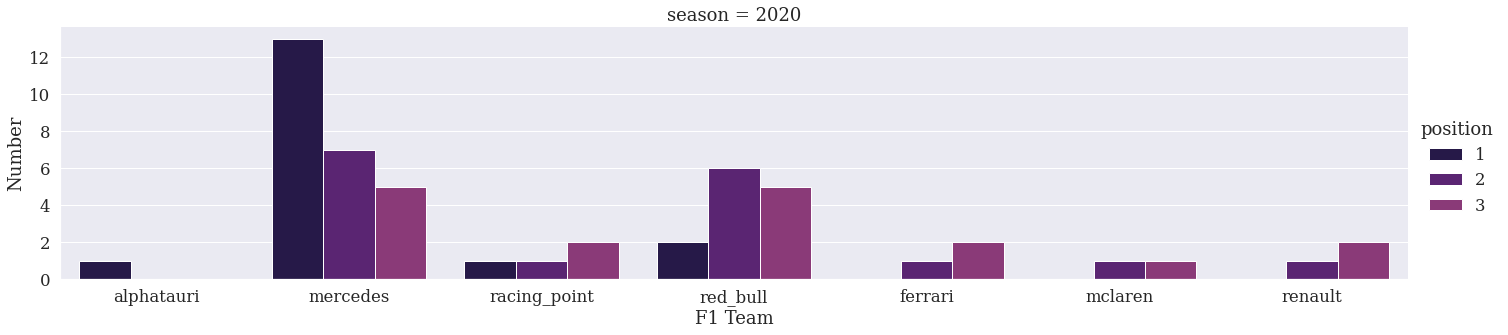

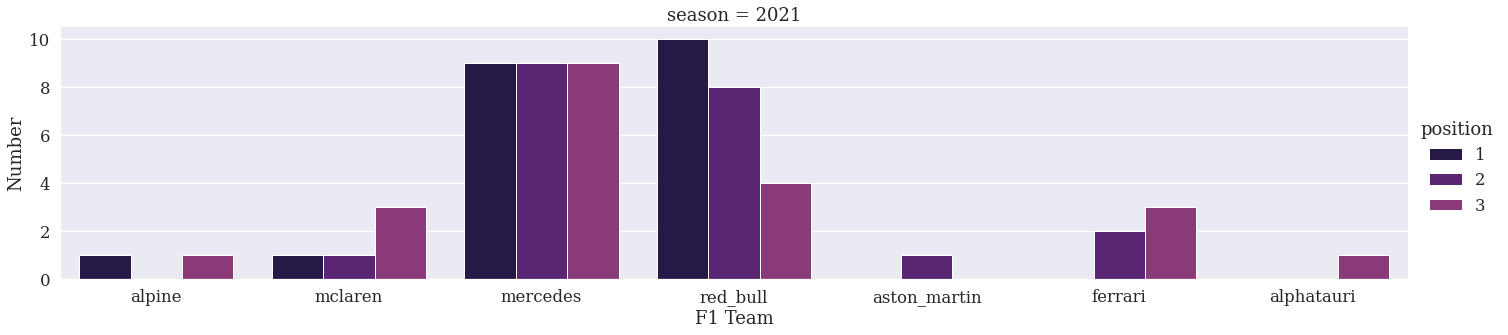

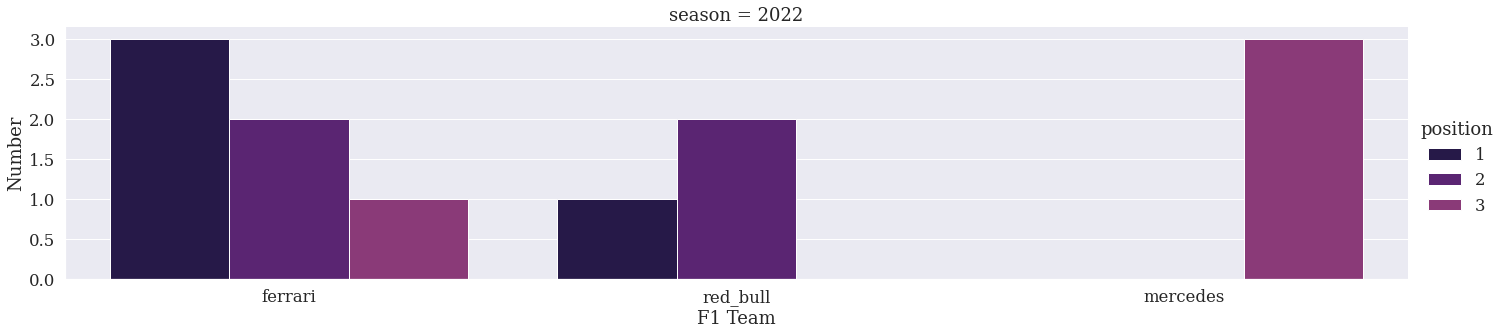

In [1249]:
#Ending in top 3 and counting how many times in each position per driver
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.5,font="serif")

#Plot
for i in Years:
    if i<=2016:
        continue
    else:
        g = sns.catplot(x='Constructor.constructorId',y="Number", col="season",kind="bar",height=5,aspect=4,hue="position",
            data=PositionsPerTeam[PositionsPerTeam["season"]==i])
        plt.xlabel("F1 Team")
        # plt.ylabel("Times")


plt.show()

##### Starting the race in front row per driver (2017-2021)

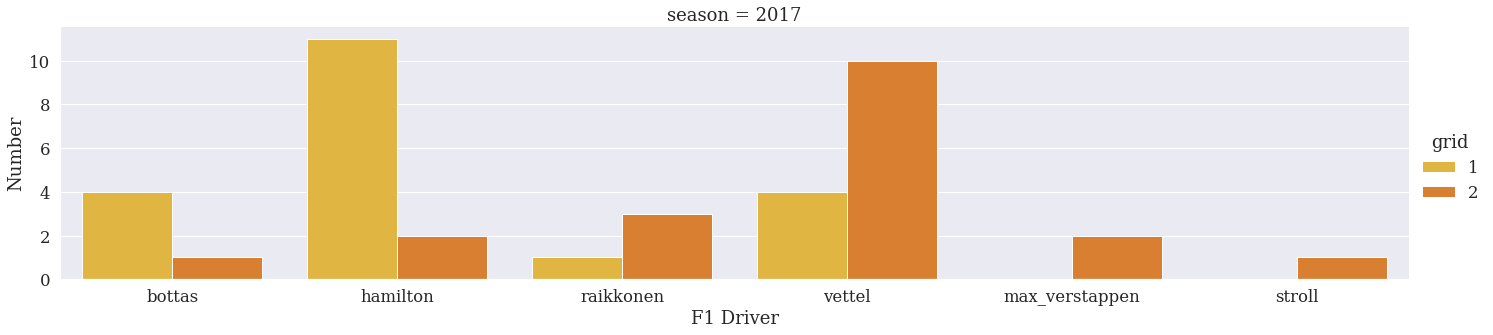

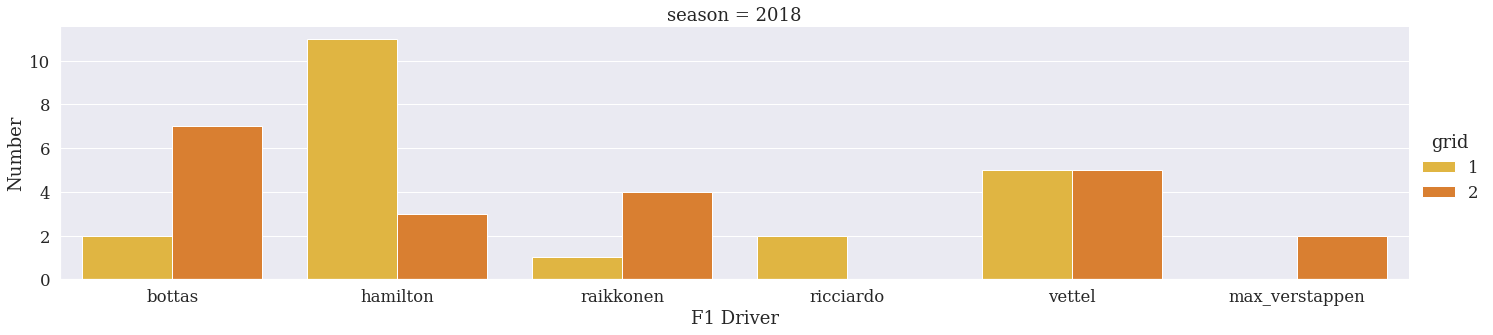

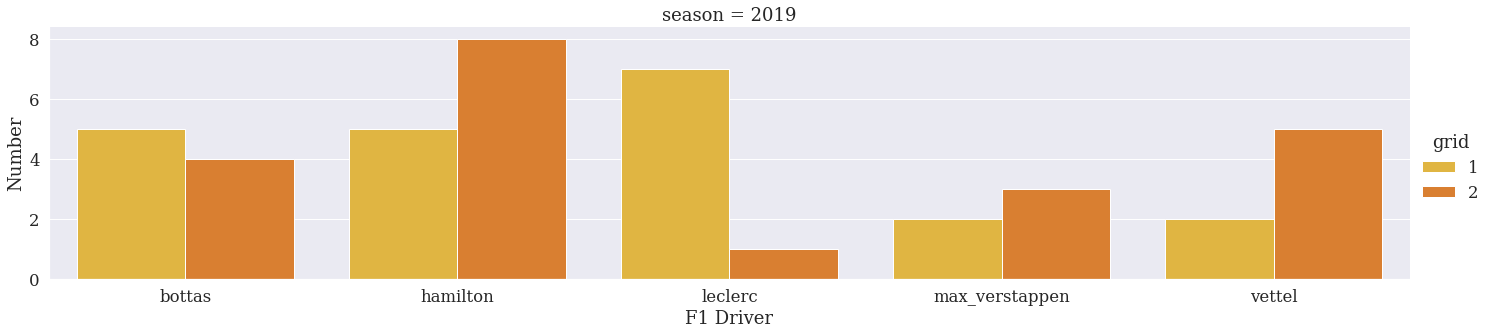

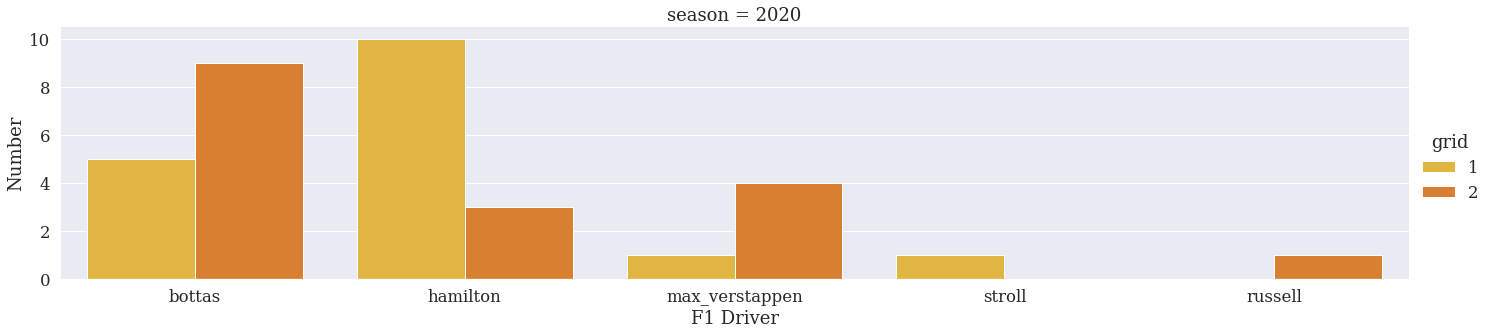

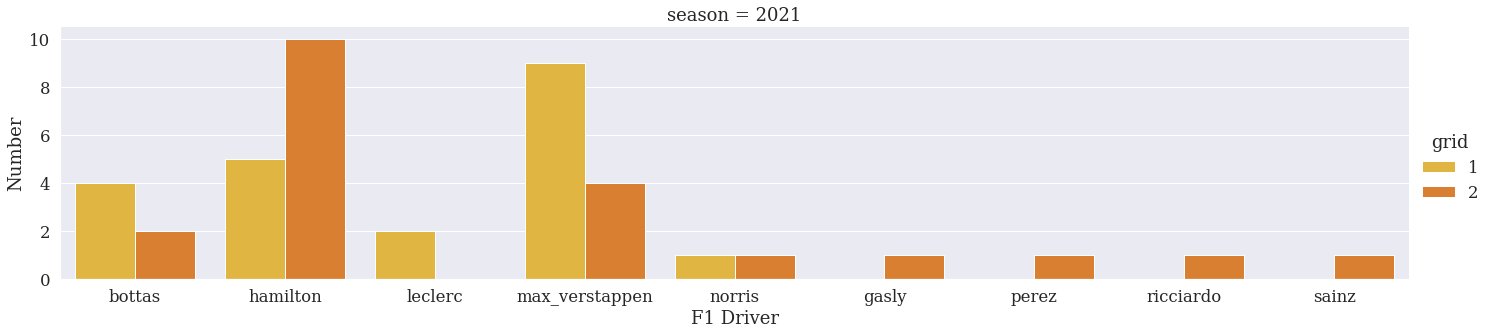

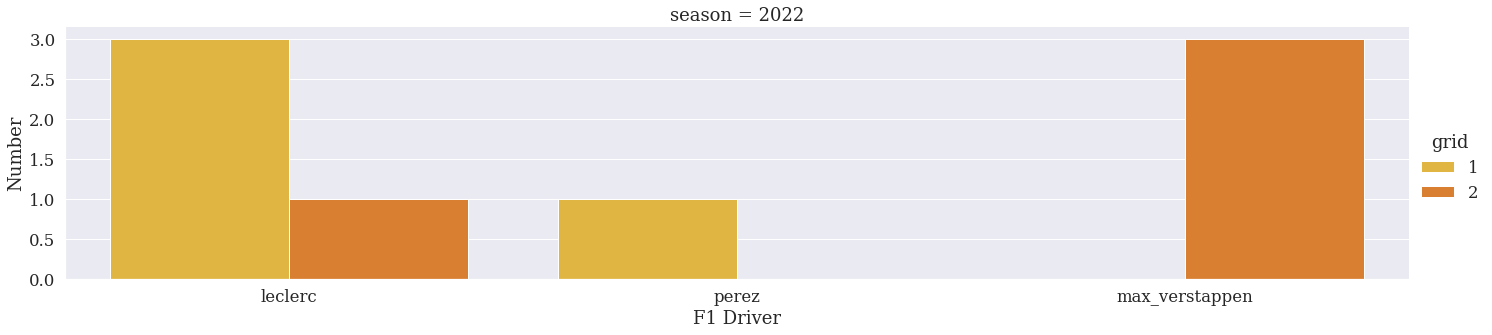

In [1250]:
#Front position per driver
sns.set_theme(style="darkgrid", palette="inferno_r",font_scale=1.5,font="serif")

#Plot
for i in Years:
    if i<=2016:
        continue
    else:
        g = sns.catplot(x='Driver.driverId',y="Number", col="season",kind="bar",height=5,aspect=4,hue="grid",
            data=GridPerDriver[GridPerDriver["season"]==i])
        plt.xlabel("F1 Driver")
        # plt.ylabel("Times")

plt.show()

##### Starting the race in front row per team (2017-2021)

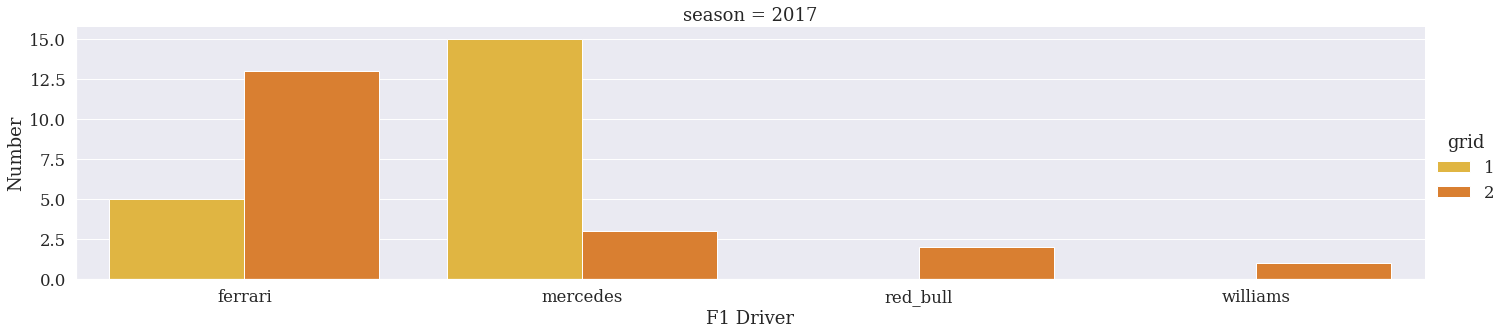

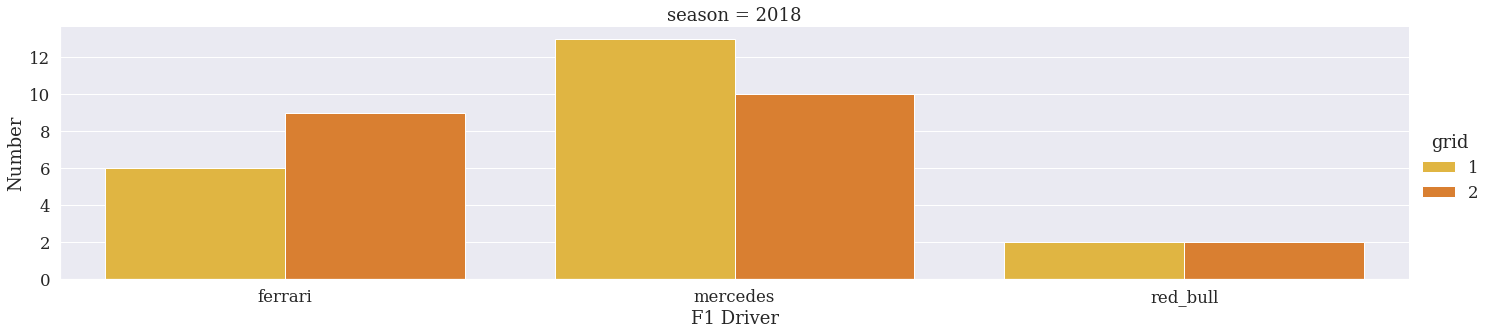

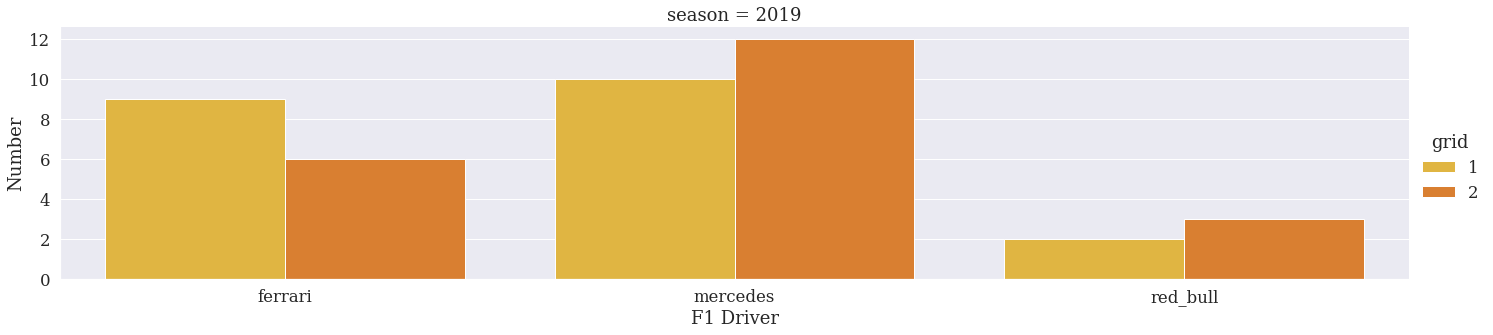

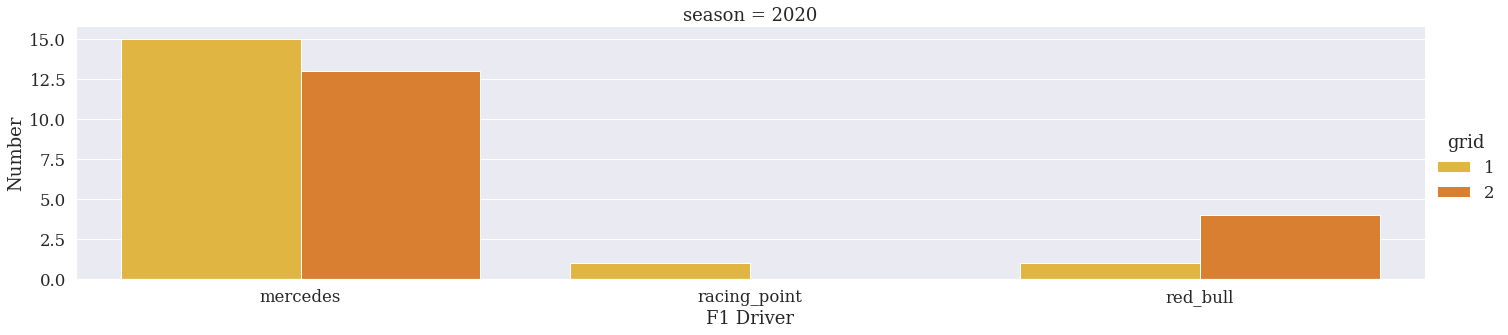

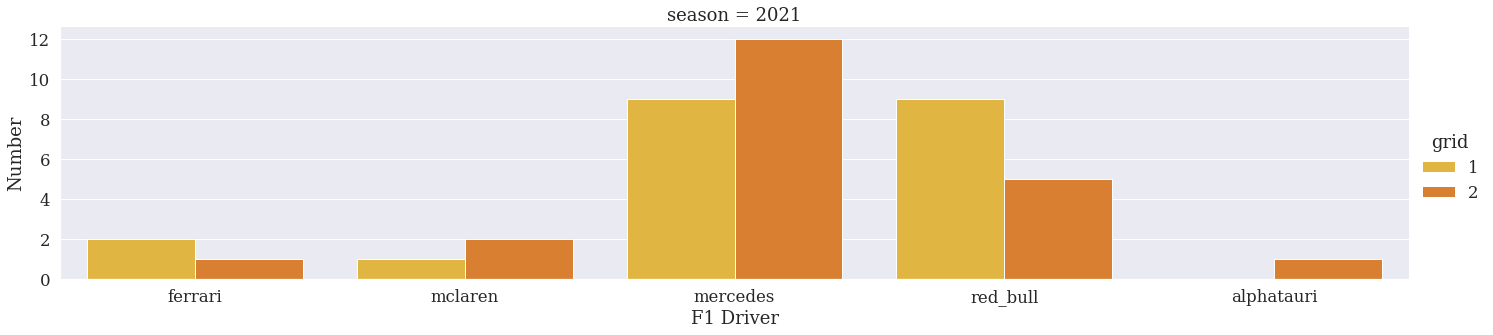

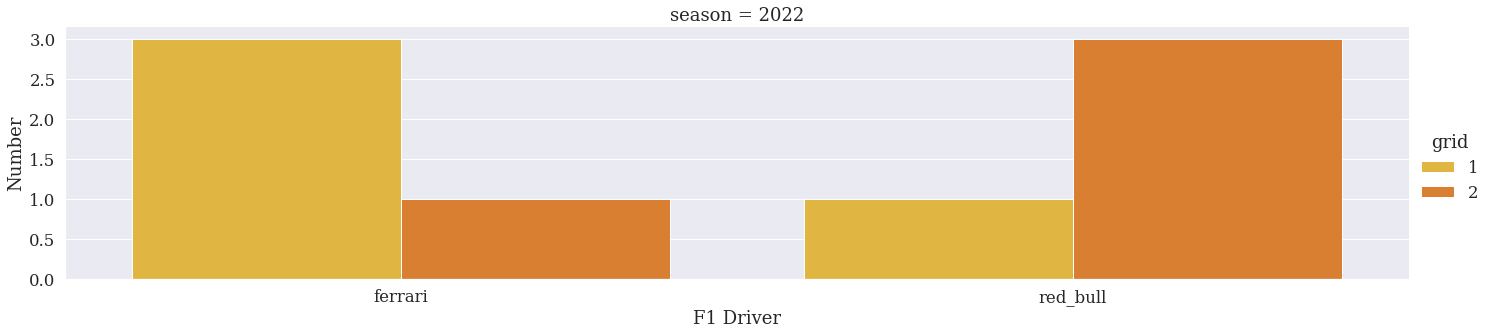

In [1251]:
#Front position per driver
sns.set_theme(style="darkgrid", palette="inferno_r",font_scale=1.5,font="serif")

#Plot
for i in Years:
    if i<=2016:
        continue
    else:
        g = sns.catplot(x='Constructor.constructorId',y="Number", col="season",kind="bar",height=5,aspect=4,hue="grid",
            data=GridPerTeam[GridPerTeam["season"]==i])
        plt.xlabel("F1 Driver")
        # plt.ylabel("Times")

plt.show()

#### C. Between this race and the last one

##### Final Position Vs Previous Final Position

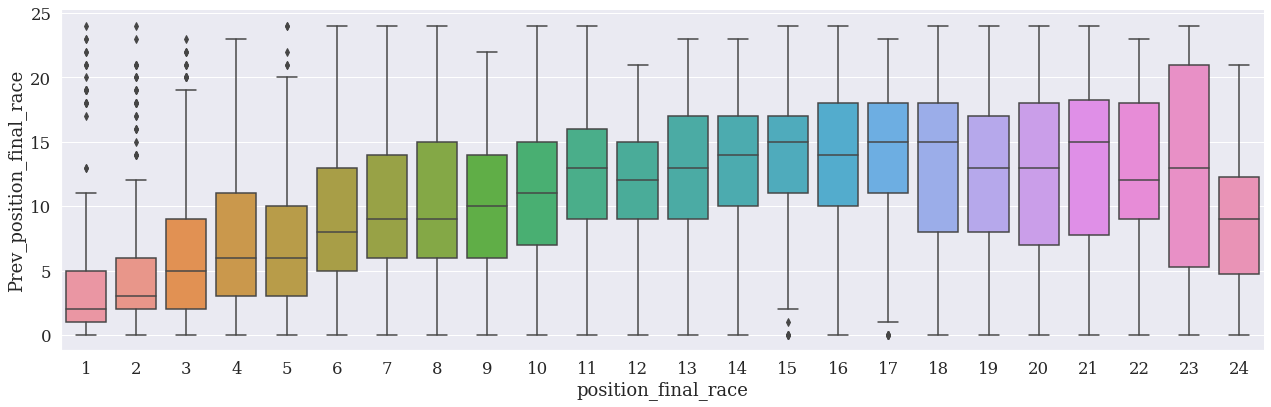

In [1252]:
sns.catplot(y="Prev_position_final_race",x='position_final_race', kind="box",data=SelectedResults,height=6,aspect=3)

##### Grid vs Prev Grid

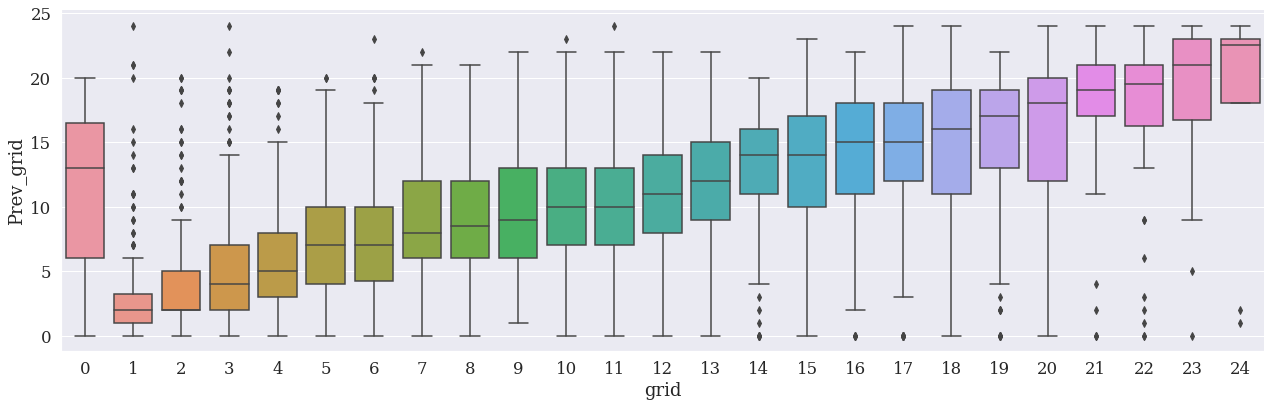

In [1253]:

sns.catplot(y="Prev_grid",x="grid", kind="box",data=SelectedResults[SelectedResults["Completed"]=="Completed"],height=6,aspect=3)

##### Final Position in the race vs Starting Grid

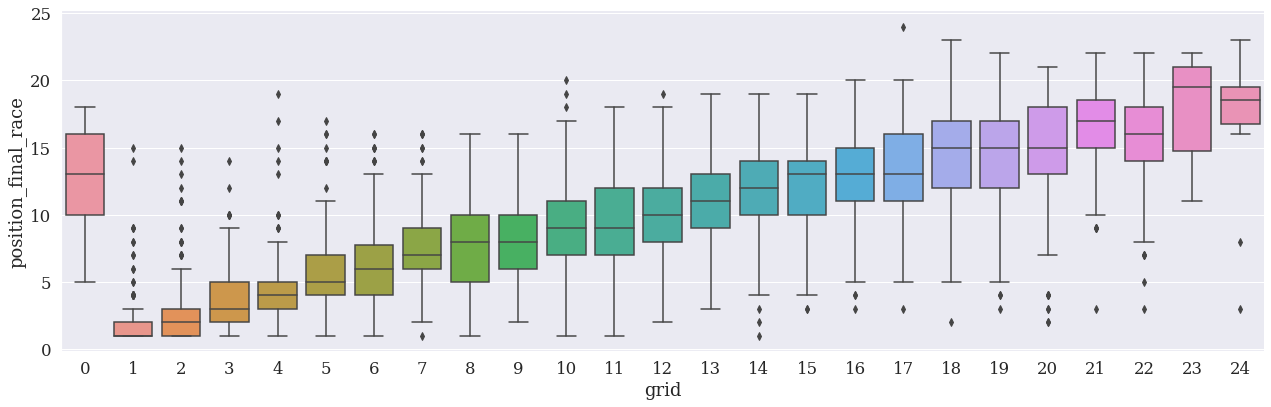

In [1254]:
g=sns.catplot(y='position_final_race',x="grid", kind="box",data=SelectedResults[SelectedResults["Completed"]=="Completed"],height=6,aspect=3)


775

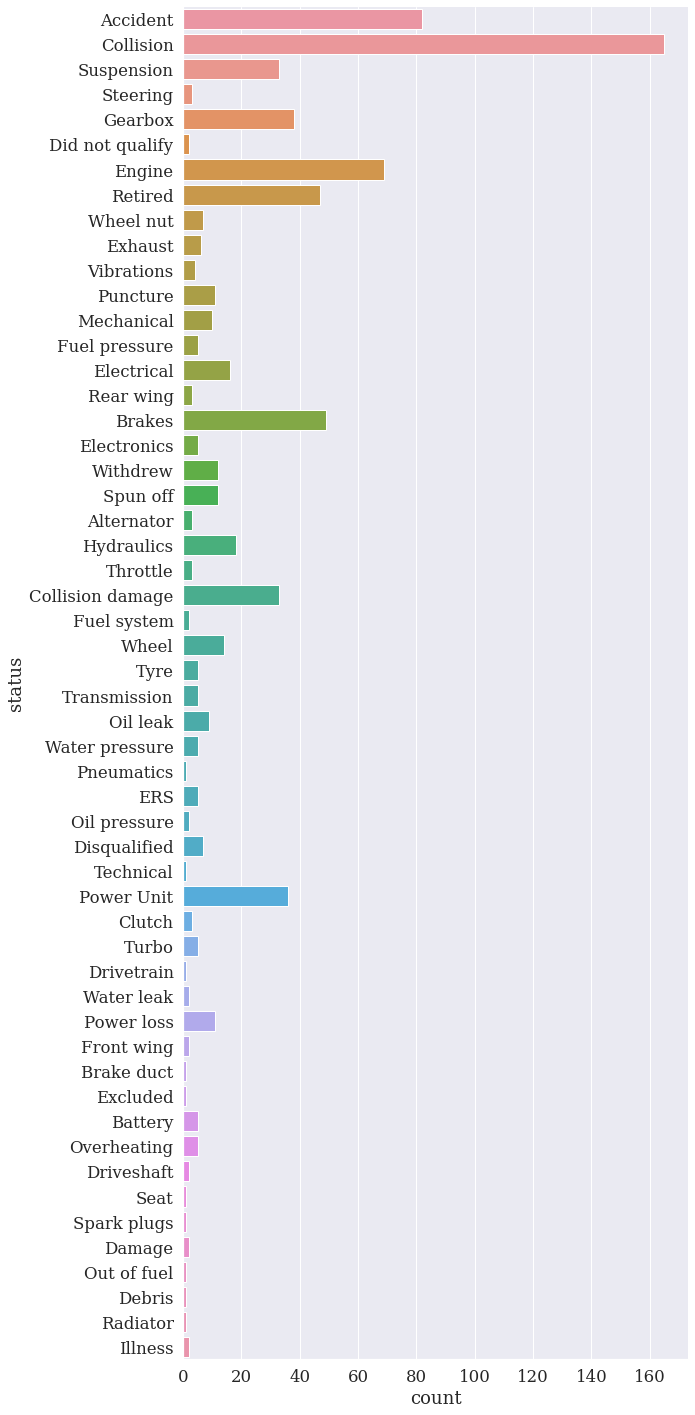

In [1255]:
g=sns.catplot(y="status", kind="count",data=SelectedResults[SelectedResults["Completed"]!="Completed"],height=20,aspect=0.5)
len(SelectedResults[SelectedResults["Completed"]!="Completed"]) #3430 out 775



## III. Random Forest Classifier

### Functions to test the scores:

In [1256]:
#Set scorers
f1_scorer=make_scorer(f1_score,average="weighted")
accuracy_scorer=make_scorer(accuracy_score)

### Function to test and evaluate the algorithms


def evaluating(y_train,y_train_predicted,y_test,y_test_predicted):
    y_true = y_train 
    y_pred = y_train_predicted 

    print("\n Training Scores:")
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
    print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
    print('Max Error:', metrics.max_error(y_true, y_pred))
    print('R^2:', metrics.r2_score(y_true, y_pred))

    print("F1 Score:",f1_score(y_true, y_pred,average="weighted"))
    print("Recall:",recall_score(y_true,y_pred,average="weighted"))
    print("Precision:",precision_score(y_true,y_pred,average="weighted"))

    y_true = y_test 
    y_pred = y_test_predicted 
    
    print("\n Testing Scores:")
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
    print('Max Error:', metrics.max_error(y_true, y_pred))
    print('R^2:', metrics.r2_score(y_true, y_pred))

    print("F1 Score:",f1_score(y_true, y_pred,average="weighted"))
    print("Recall:",recall_score(y_true,y_pred,average="weighted"))
    print("Precision:",precision_score(y_true,y_pred,average="weighted"))

In [1257]:
### Function to test and evaluate the algorithms
def testing_the_classifier(tickstrain,tickstest,thesize=(10,10)):
    Train=pd.DataFrame()
    Train["Predicted"]=y_train_predicted
    Train["Real"]=y_train.tolist()

    Test=pd.DataFrame()
    Test["Predicted"]=y_test_predicted
    Test["Real"]=y_test.tolist()

    #Generate the confusion matrixes

    cf_matrixtrain = confusion_matrix(Train["Real"], Train["Predicted"])
    cf_matrixtest = confusion_matrix(Test["Real"], Test["Predicted"])

    print("\n Training Data:")
    sns.set_theme(style="whitegrid", palette="BuPu",font_scale=1,font="serif")
    plt.figure(figsize=thesize)
    ax = sns.heatmap(cf_matrixtrain, annot=True,cmap="BuPu",fmt='d')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(tickstrain)
    ax.yaxis.set_ticklabels(tickstrain)
    plt.show()

    print(classification_report(y_train, y_train_predicted))

    print("F1 Score:",f1_score(y_train, y_train_predicted,average="weighted"))
    print("Recall:",recall_score(y_train,y_train_predicted,average="weighted"))
    print("Precision:",precision_score(y_train,y_train_predicted,average="weighted"))

    

    print("\n Testing Data:")
    sns.set_theme(style="whitegrid", palette="BuPu",font_scale=1,font="serif")
    plt.figure(figsize=thesize)
    ax = sns.heatmap(cf_matrixtest, annot=True,cmap="BuPu",fmt='d')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(tickstest)
    ax.yaxis.set_ticklabels(tickstest)
    plt.show()

    print(classification_report(y_test, y_test_predicted))

    print("F1 Score:",f1_score(y_test, y_test_predicted,average="weighted"))
    print("Recall:",recall_score(y_test, y_test_predicted,average="weighted"))
    print("Precision:",precision_score(y_test, y_test_predicted,average="weighted"))

### Creating dataframe and seeing correlation between features preselected

In [1258]:
ResultsExpandedDF=createResultsExpanded(0.70,5) #percentile #number of previous laps information

In [1259]:
ResultsExpandedDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3430 entries, 0 to 3429
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Season-Round                           3430 non-null   object 
 1   Season-Round-DriverID                  3430 non-null   object 
 2   Podium                                 3430 non-null   object 
 3   position_final_race                    3430 non-null   int64  
 4   points                                 3430 non-null   float64
 5   grid                                   3430 non-null   int64  
 6   laps_total_race                        3430 non-null   int64  
 7   status                                 3430 non-null   object 
 8   driverId                               3430 non-null   object 
 9   Driver.nationality                     3430 non-null   object 
 10  Circuit.circuitId                      3430 non-null   object 
 11  Cons

In [1260]:
#Filling the prev status with "not spcified"
ResultsExpandedDF['Prev_status']=ResultsExpandedDF['Prev_status'].replace(0,"Not Specified")

In [1261]:
status_encoder = LabelEncoder()
status_encoder.fit(ResultsExpandedDF['Prev_status'])
status_values=status_encoder.transform(ResultsExpandedDF['Prev_status'])
ResultsExpandedDF['Prev_status_encoded']=status_values

In [1396]:
cannot_take_into_account=['status','Time.millis','FastestLap.rank','FastestLap.lap',"points",
                            'FastestLap.Time.time_in_seconds','FastestLap.AverageSpeed.speedKph']

encodedfeatures=['driverId','Circuit.circuitId','Constructor.constructorId','Prev_status']

not_useful=['Season-Round','Season-Round-DriverID','Driver.nationality','Constructor.nationality',"Completed",
            ]

cont=['position_final_race','Prev_Time.millis','Prev_FastestLap.Time.time_in_seconds',
       "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
       'Prev_FastestLap.AverageSpeed.speedKph',
       'Fastest_per_driver', 'Fastest_per_race','lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
       'lap_4_duration_secs', 'lap_5_duration_secs']
cat=['position_final_race','grid', 'laps_total_race','season', 'round','driverId_encoded',
       'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
       'Prev_position_final_race', 'Prev_grid',
       'Prev_FastestLap.rank', 'Prev_FastestLap.lap','laps_considered',
       'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded'] #,"Podium"

print(len(cannot_take_into_account)+len(encodedfeatures)+len(not_useful)+len(cat)+len(cont)-1)
print(len(ResultsExpandedDF.columns))

united=np.concatenate([cat,cont[1:]])


48
50


In [1392]:
#ResultsExpandedDF[cont].corr(method='pearson')["position_final_race"]
# ResultsExpandedDF[cat].corr(method='kendall')["position_final_race"]

<AxesSubplot:>

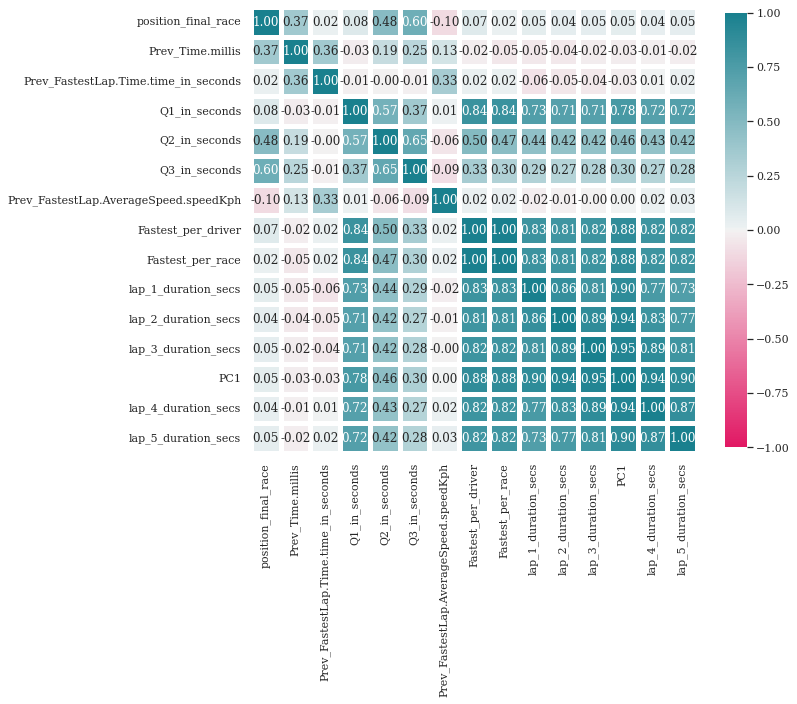

In [1395]:
import seaborn as sns
import matplotlib.pyplot as plt

#Calculating correlation: Heatmap
sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(0, 210, 95, 49, as_cmap=True)
sns.heatmap(ResultsExpandedDF[cont].corr(method='pearson'), annot=True, fmt=".2f", 
           linewidths=5,cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)

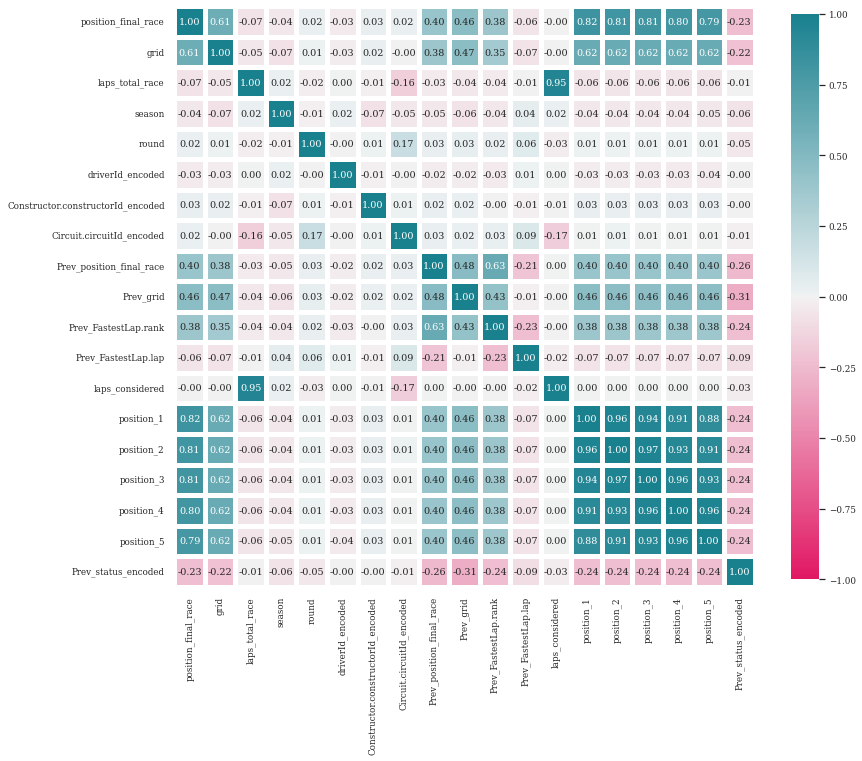

In [1265]:
import seaborn as sns
import matplotlib.pyplot as plt

#Calculating correlation: Heatmap
sns.set_theme(style="whitegrid", palette="magma",font_scale=0.8,font="serif")
fig, ax = plt.subplots(figsize=(13, 13))
cmap = sns.diverging_palette(0, 210, 95, 49, as_cmap=True)
sns.heatmap(ResultsExpandedDF[cat].corr(method='kendall'), annot=True, fmt=".2f", 
           linewidths=5,cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)

plt.show()

<AxesSubplot:>

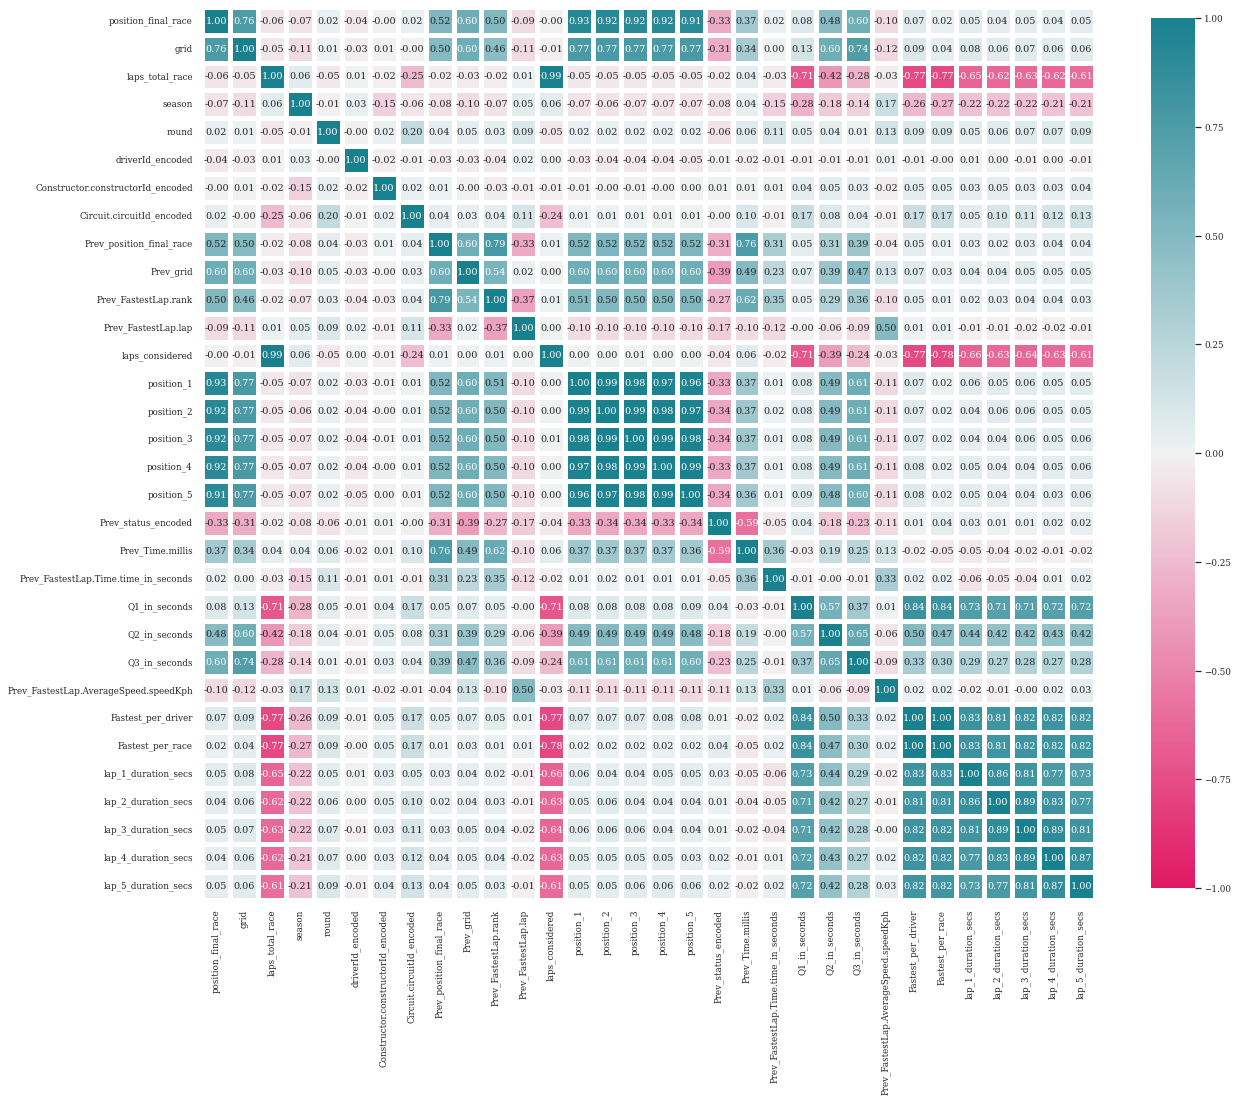

In [1415]:
sns.set_theme(style="whitegrid", palette="magma",font_scale=0.8,font="serif")
fig, ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(0, 210, 95, 49, as_cmap=True)
sns.heatmap(ResultsExpandedDF[united].corr(method='pearson'), annot=True, fmt=".2f", 
           linewidths=5,cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)


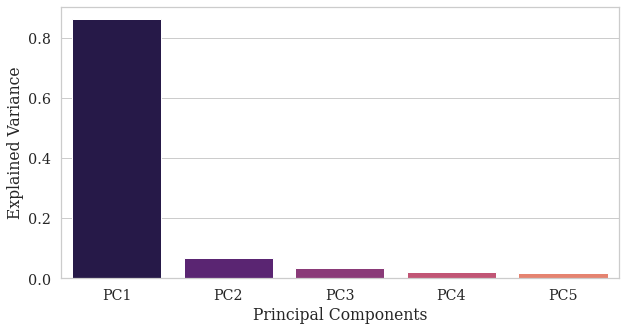

,PC,Ex Var,Ex Var Cumulative
0,PC1,0.860056,0.860056
1,PC2,0.065975,0.926031
2,PC3,0.035860,0.961891
3,PC4,0.021973,0.983863
4,PC5,0.016137,1.000000


In [1373]:
from sklearn.preprocessing import StandardScaler #to standardize values
#The Selected features are standardized
features1=['lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
       'lap_4_duration_secs', 'lap_5_duration_secs']
features2=['position_1', 'position_2', 'position_3', 'position_4', 'position_5']

scaler = StandardScaler()
scaler.fit(ResultsExpandedDF[features1]) #Scaler is fitted
F1_standardized = pd.DataFrame(scaler.transform(ResultsExpandedDF[features1]), columns=features1) 

from sklearn.decomposition import PCA
pca = PCA(n_components=5) # 6 PCA's
Components = pca.fit_transform(F1_standardized) 
ComponentsDF=pd.DataFrame(data=Components, columns=["PC1","PC2","PC3","PC4","PC5"])

#Explained variances of each PC
explained_variances = pca.explained_variance_ratio_
explained_variances_cumulative=np.cumsum(pca.explained_variance_ratio_)
explained_variancesDF=pd.DataFrame({"PC":["PC1","PC2","PC3","PC4","PC5"],"Ex Var":explained_variances,"Ex Var Cumulative":explained_variances_cumulative})
explained_variancesDF #Explained variances in dataframe form

#Explained Variance plot
sns.set_theme(style="whitegrid", palette="magma",font_scale=1.3,font="serif")
fig, ax = plt.subplots(figsize=(10, 5))
ax=sns.barplot(x="PC",y="Ex Var",data=explained_variancesDF)
ax.set(ylabel="Explained Variance",
       xlabel="Principal Components")
plt.show()

explained_variancesDF

In [1424]:
ResultsExpandedDF["PC_LapsDuration"]=ComponentsDF["PC1"]

### Backwards Elimintation

In [1479]:
np.random.seed(1994)

def back(measure):
    len_ind=len(independent_original)
    for i in range(len_ind):
       a=independent_original[:i]
       b=independent_original[i+1:]
       c=a+b
       X_train, X_test, y_train, y_test = train_test_split(ResultsExpandedDF[c], ResultsExpandedDF[dependent], test_size=0.20,random_state=1994)
       X_trainn, X_val, y_trainn, y_val = train_test_split(X_train, y_train, test_size=0.20,random_state=1994)
       measureslist=[]
       for r in range(100):
          RF=RandomForestClassifier(n_estimators=50)
          RF.fit(X_trainn,y_trainn)
          y_val_predicted=RF.predict(X_val)
          
          y_true = y_val 
          y_pred = y_val_predicted
          measureslist+=[measure(y_true, y_pred)]
          measures_array=np.array(measureslist)
          avgmeasures=np.mean(measures_array)
       print("erased: ",independent_original[i],' - ',str(avgmeasures))

def backf1():
    len_ind=len(independent_original)
    for i in range(len_ind):
       a=independent_original[:i]
       b=independent_original[i+1:]
       c=a+b
       X_train, X_test, y_train, y_test = train_test_split(ResultsExpandedDF[c], ResultsExpandedDF[dependent], test_size=0.20,random_state=1994)
       X_trainn, X_val, y_trainn, y_val = train_test_split(X_train, y_train, test_size=0.20)
       measureslist=[]
       for r in range(100):
          RF=RandomForestClassifier(n_estimators=50)
          RF.fit(X_trainn,y_trainn)
          y_val_predicted=RF.predict(X_val)
          
          y_true = y_val 
          y_pred = y_val_predicted
          measureslist+=[f1_score(y_true, y_pred,average="weighted")]
          measures_array=np.array(measureslist)
          avgmeasures=np.mean(measures_array)
       print("erased: ",independent_original[i],' - ',str(avgmeasures))



def backtotalf1():
   len_ind=len(independent_original)

   X_train, X_test, y_train, y_test = train_test_split(ResultsExpandedDF[independent_original], ResultsExpandedDF[dependent], test_size=0.20,random_state=1994)
   X_trainn, X_val, y_trainn, y_val = train_test_split(X_train, y_train, test_size=0.20)
   measureslist=[]
   for r in range(100):
      # RF=RandomForestClassifier(n_estimators=100)
      RF=THE_CHOSEN_ONE
      RF.fit(X_trainn,y_trainn)
      y_val_predicted=RF.predict(X_val)
      
      y_true = y_val 
      y_pred = y_val_predicted
      measureslist+=[f1_score(y_true, y_pred,average="weighted")]
      measures_array=np.array(measureslist)
      avgmeasures=np.mean(measures_array)
   print(' - ',str(avgmeasures))

def backtotal(measure):
   len_ind=len(independent_original)

   X_train, X_test, y_train, y_test = train_test_split(ResultsExpandedDF[independent_original], ResultsExpandedDF[dependent], test_size=0.20,random_state=1994)
   X_trainn, X_val, y_trainn, y_val = train_test_split(X_train, y_train, test_size=0.20)
   measureslist=[]
   for r in range(100):
      RF=THE_CHOSEN_ONE
      RF.fit(X_trainn,y_trainn)
      y_val_predicted=RF.predict(X_val)
      
      y_true = y_val 
      y_pred = y_val_predicted
      measureslist+=[measure(y_true, y_pred)]
      measures_array=np.array(measureslist)
      avgmeasures=np.mean(measures_array)
   print(' - ',str(avgmeasures))

In [1480]:
dependent='position_final_race'
#With all the initial values
# independent_original=['Prev_Time.millis','Prev_FastestLap.Time.time_in_seconds',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver', 'Fastest_per_race','lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
#        'lap_4_duration_secs', 'lap_5_duration_secs','grid', 'laps_total_race','season', 'round','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap','laps_considered',
#        'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded']


#Taking 'laps_total_race' out
# independent_original=['Prev_Time.millis','Prev_FastestLap.Time.time_in_seconds',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver', 'Fastest_per_race','lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
#        'lap_4_duration_secs', 'lap_5_duration_secs','grid','season', 'round','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap','laps_considered',
#        'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded']

#Taking 'Fastest_per_race' out
# independent_original=['Prev_Time.millis','Prev_FastestLap.Time.time_in_seconds',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver','lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
#        'lap_4_duration_secs', 'lap_5_duration_secs','grid','season', 'round','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap','laps_considered',
#        'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded']

#taking "round" out
# independent_original=['Prev_Time.millis','Prev_FastestLap.Time.time_in_seconds',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver','lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
#        'lap_4_duration_secs', 'lap_5_duration_secs','grid','season','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap','laps_considered',
#        'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded']

# #taking 'Prev_FastestLap.Time.time_in_seconds' out
# independent_original=['Prev_Time.millis',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver','lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
#        'lap_4_duration_secs', 'lap_5_duration_secs','grid','season','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap','laps_considered',
#        'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded']

#taking laps considered
# independent_original=['Prev_Time.millis',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver','lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
#        'lap_4_duration_secs', 'lap_5_duration_secs','grid','season','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap',
#        'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded']

# #taking lap duration out and inserting pca
# independent_original=['Prev_Time.millis',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver','grid','season','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap',
#        'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded',"PC_LapsDuration"]
       
#just taking lap duration out 
independent_original=['Prev_Time.millis',
       "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
       'Prev_FastestLap.AverageSpeed.speedKph',
       'Fastest_per_driver','grid','season','driverId_encoded',
       'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
       'Prev_position_final_race', 'Prev_grid',
       'Prev_FastestLap.rank', 'Prev_FastestLap.lap',
       'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded']



In [1444]:
backf1()

erased:  Prev_Time.millis  -  0.314606953066648
erased:  Q1_in_seconds  -  0.3169241365647931
erased:  Q2_in_seconds  -  0.31776550651843105
erased:  Q3_in_seconds  -  0.3300496497888296
erased:  Prev_FastestLap.AverageSpeed.speedKph  -  0.3153403744409641
erased:  Fastest_per_driver  -  0.320828254247965
erased:  grid  -  0.29887913316135983
erased:  season  -  0.3023942165098757
erased:  driverId_encoded  -  0.33743702483330645
erased:  Constructor.constructorId_encoded  -  0.3238567124480507
erased:  Circuit.circuitId_encoded  -  0.3107548812010482
erased:  Prev_position_final_race  -  0.32086790568495055
erased:  Prev_grid  -  0.3048341931519556
erased:  Prev_FastestLap.rank  -  0.3275794514101226
erased:  Prev_FastestLap.lap  -  0.3054008714521327
erased:  position_1  -  0.3095987296949341
erased:  position_2  -  0.3050896133236736
erased:  position_3  -  0.32090607217320477
erased:  position_4  -  0.29624890826803774
erased:  position_5  -  0.32880115572707785
erased:  Prev_statu

In [ ]:
#back(metrics.mean_absolute_error)

In [1446]:
back(accuracy_score)


erased:  Prev_Time.millis  -  0.31591985428051
erased:  Q1_in_seconds  -  0.31921675774134795
erased:  Q2_in_seconds  -  0.31619307832422583
erased:  Q3_in_seconds  -  0.31810564663023677
erased:  Prev_FastestLap.AverageSpeed.speedKph  -  0.31894353369763206
erased:  Fastest_per_driver  -  0.316976320582878
erased:  grid  -  0.31043715846994535
erased:  season  -  0.3149180327868852
erased:  driverId_encoded  -  0.3129143897996357
erased:  Constructor.constructorId_encoded  -  0.3191256830601093
erased:  Circuit.circuitId_encoded  -  0.3178688524590164
erased:  Prev_position_final_race  -  0.3176138433515483
erased:  Prev_grid  -  0.31362477231329683
erased:  Prev_FastestLap.rank  -  0.3171402550091074
erased:  Prev_FastestLap.lap  -  0.31216757741347906
erased:  position_1  -  0.29825136612021863
erased:  position_2  -  0.305063752276867
erased:  position_3  -  0.31052823315118394
erased:  position_4  -  0.31366120218579235
erased:  position_5  -  0.3107650273224044
erased:  Prev_stat

In [1481]:
print(backtotalf1(),backtotal(accuracy_score),backtotal(metrics.mean_absolute_error))

 -  0.36702203337970585


KeyboardInterrupt: 

### Individual Training and testing

In [1450]:
# independent_original=['Prev_Time.millis','Prev_FastestLap.Time.time_in_seconds',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver', 'Fastest_per_race','lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
#        'lap_4_duration_secs', 'lap_5_duration_secs','grid', 'laps_total_race','season', 'round','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap','laps_considered',
#        'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded'] #,"Podium"

dependent='position_final_race'


In [1467]:
#Divide data into training and testing - stratified
from sklearn.model_selection import train_test_split #separte train and test data

X_train, X_test, y_train, y_test = train_test_split(ResultsExpandedDF[independent_original], ResultsExpandedDF[dependent], test_size=0.20,random_state=1994)


In [1324]:
# X_train=X_train.drop(columns=["Podium"])
# y_test=y_test[(y_test==1) | (y_test==2) | (y_test==3)]
# X_test=X_test[X_test["Podium"]=="Podium"]
# X_test=X_test.drop(columns=["Podium"])

In [1474]:
import sklearn

from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(random_state=22, bootstrap=True,class_weight="balanced",criterion="entropy",max_features=None,n_estimators=300,min_samples_leaf=3,max_depth=30,max_leaf_nodes=None,min_samples_split=3)
RF.fit(X_train,y_train)
y_train_predicted=RF.predict(X_train)
y_test_predicted=RF.predict(X_test)

mse_train = mean_squared_error(y_train,y_train_predicted)
mse_test = mean_squared_error(y_test,y_test_predicted)
print(mse_train,"-",mse_test)


1.1479591836734695 - 4.15597667638484


In [1475]:
TRAINN=list(range(1,(y_train_predicted.max()+1)))
TESTT=list(range(1,(y_test_predicted.max()+1)))

In [1476]:
evaluating(y_train,y_train_predicted,y_test,y_test_predicted)


 Training Scores:
Mean Absolute Error (MAE): 0.20626822157434402
Mean Squared Error (MSE): 1.1479591836734695
Explained Variance Score: 0.9576003275525997
Max Error: 14
R^2: 0.9576000136094361
F1 Score: 0.9480990145999092
Recall: 0.9475218658892128
Precision: 0.9498003197403159

 Testing Scores:
Mean Absolute Error (MAE): 1.3221574344023324
Mean Squared Error (MSE): 4.15597667638484
Max Error: 11
R^2: 0.8456549440765458
F1 Score: 0.3419093751385604
Recall: 0.3396501457725947
Precision: 0.3551947164431403


C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Training Data:


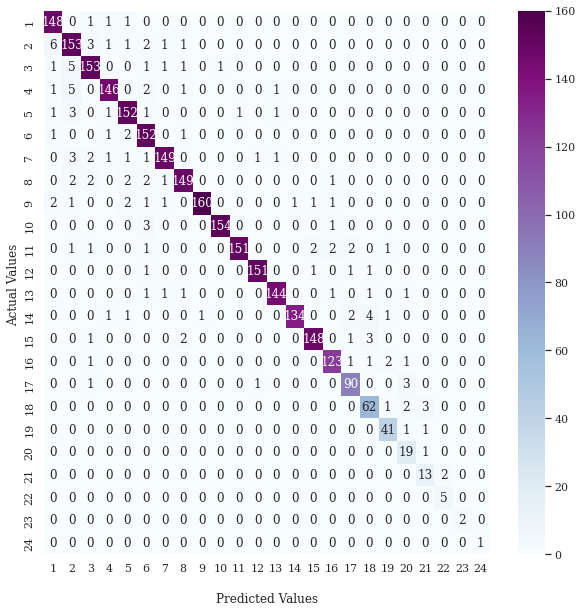

              precision    recall  f1-score   support

           1       0.93      0.98      0.95       151
           2       0.88      0.91      0.90       168
           3       0.93      0.94      0.93       163
           4       0.96      0.94      0.95       156
           5       0.94      0.95      0.94       160
           6       0.90      0.97      0.94       157
           7       0.97      0.94      0.95       159
           8       0.96      0.94      0.95       159
           9       0.99      0.94      0.97       170
          10       0.99      0.97      0.98       158
          11       0.99      0.94      0.96       161
          12       0.99      0.97      0.98       155
          13       0.98      0.96      0.97       150
          14       0.99      0.93      0.96       144
          15       0.97      0.95      0.96       155
          16       0.95      0.95      0.95       129
          17       0.93      0.95      0.94        95
          18       0.86    

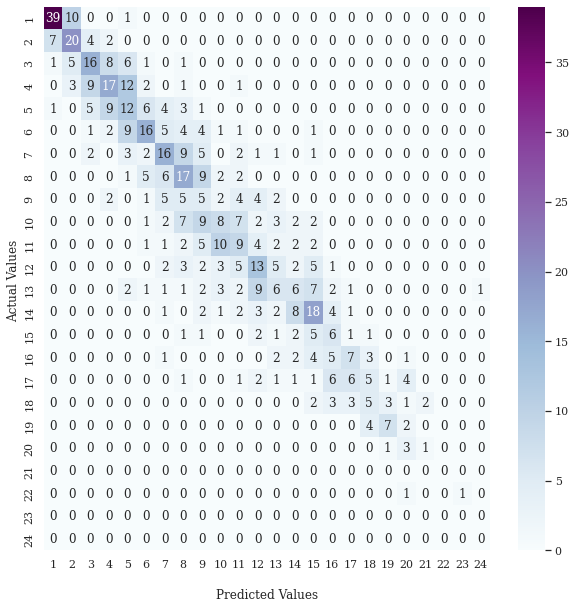

              precision    recall  f1-score   support

           1       0.81      0.78      0.80        50
           2       0.53      0.61      0.56        33
           3       0.43      0.42      0.43        38
           4       0.42      0.38      0.40        45
           5       0.26      0.29      0.28        41
           6       0.44      0.36      0.40        44
           7       0.36      0.38      0.37        42
           8       0.31      0.40      0.35        42
           9       0.11      0.17      0.13        30
          10       0.27      0.19      0.22        43
          11       0.25      0.24      0.24        38
          12       0.33      0.32      0.32        41
          13       0.24      0.14      0.17        44
          14       0.32      0.19      0.24        42
          15       0.10      0.25      0.15        20
          16       0.19      0.20      0.19        25
          17       0.32      0.21      0.25        29
          18       0.28    

C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [1477]:
testing_the_classifier(TRAINN,TESTT)

Text(0, 0.5, 'Mean decrease in impurity')

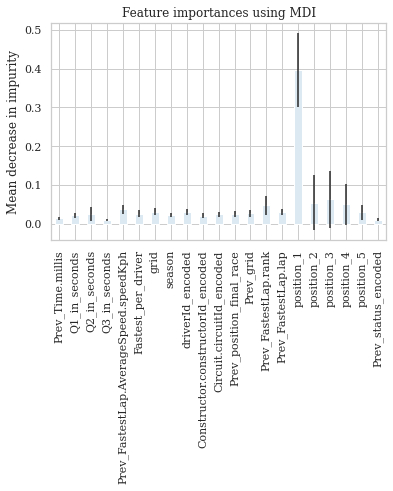

In [1478]:
#Importances

importances = RF.feature_importances_
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)

forest_importances = pd.Series(importances, index=independent_original)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

#### Individual Metrics (do not use)

In [1305]:


def classification_g_report(clase):

    CONF=confusion_matrix(y_test_predicted,y_test)
    ii=clase-1
    All=CONF.sum()

    TP=CONF[ii,ii]

    FP1=CONF[:][ii][:ii]
    FP2=CONF[:][ii][clase:]
    FP=np.concatenate((FP1,FP2))
    sumFP=FP.sum()

    FN1=CONF[:,ii][:ii]
    FN2=CONF[:,ii][clase:]
    FN=np.concatenate((FN1,FN2))
    sumFN=FN.sum()

    sumTN=All-TP-sumFN-sumFP

    RecallL=round(TP/(sumFN+TP),3)
    PrecisionN=round(TP/(sumFP+TP),3)
    AccuracyY=round((TP+sumTN)/All,3)
    F1ScoreE=round(2*((RecallL*PrecisionN)/(RecallL+PrecisionN)),3)

    print("Podium position ",clase," - Accuracy:",AccuracyY," F1 Score:",F1ScoreE," Pres: ",PrecisionN," Recall:",RecallL)

# for i in TESTT:
#     classification_g_report(i)


Podium position  1  - Accuracy: 0.86  F1 Score: 0.828  Pres:  0.837  Recall: 0.82
Podium position  2  - Accuracy: 0.777  F1 Score: 0.597  Pres:  0.588  Recall: 0.606
Podium position  3  - Accuracy: 0.769  F1 Score: 0.517  Pres:  0.75  Recall: 0.395
Podium position  4  - Accuracy: 0.917  F1 Score: nan  Pres:  0.0  Recall: nan
Podium position  5  - Accuracy: 0.95  F1 Score: nan  Pres:  0.0  Recall: nan
Podium position  6  - Accuracy: 0.992  F1 Score: nan  Pres:  0.0  Recall: nan
Podium position  7  - Accuracy: 0.992  F1 Score: nan  Pres:  0.0  Recall: nan


C:\Users\gabri\AppData\Local\Temp\ipykernel_24616\4043553545.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
  RecallL=round(TP/(sumFN+TP),3)
C:\Users\gabri\AppData\Local\Temp\ipykernel_24616\4043553545.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
  RecallL=round(TP/(sumFN+TP),3)
C:\Users\gabri\AppData\Local\Temp\ipykernel_24616\4043553545.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
  RecallL=round(TP/(sumFN+TP),3)
C:\Users\gabri\AppData\Local\Temp\ipykernel_24616\4043553545.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
  RecallL=round(TP/(sumFN+TP),3)


### Hyperparameter optimization

In [ ]:
#SelectedResults[['season']] #min 2012-2022
#SelectedResults[["round"]].min() #1
SelectedResults[["round"]].max() #22
SelectedResults.groupby(["season"])["round"].max()
SelectedResults[SelectedResults["status"]=="Finished"].groupby(["season"])['laps_total_race'].max() #MAX87 #min 44

In [1466]:
# from sklearn.ensemble import RandomForestClassifier

# #Cross Validation using Grid Search
# RF=RandomForestClassifier(bootstrap=True,class_weight="balanced",criterion="entropy",max_features=None,n_estimators=300,min_samples_leaf=3)
# tuned_parameters = {
#     # "n_estimators":[100,150,200,300], #gini con 200 y entropy con 300. Wins entropy con 300
#     # 'criterion': ["gini","entropy"], ##entrophy with 200
#     'max_depth': [None,20,30], #CHOSEN 30
#     'min_samples_split': [2,3], #CHOSEN 3
#     # 'min_samples_leaf': [3,4,5], #in tests before only 3 were selected
#     # "max_features":["auto","sqrt","log2",None], #none is always chosen
#     "max_leaf_nodes":[None,50,70]} #CHOSEN 70
#     # 'bootstrap': [False,True], #it always shows a better result with bootstrapping in this case
#     # "class_weight":["balanced","balanced_subsample",None]}

# for x in [5,7]:
#     clf1 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=f1_scorer)
#     clf1.fit(X_train, y_train)
#     print("Folds: ",x,"- F1 Scorer: ",clf1.best_score_," ",clf1.best_params_)

# for x in [5,7]:
#     clf2 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=accuracy_scorer)
#     clf2.fit(X_train, y_train)
#     print("Folds: ",x,"- Accuracy: ",clf2.best_score_," ",clf2.best_params_)

THE_CHOSEN_ONE=RandomForestClassifier(bootstrap=True,class_weight="balanced",criterion="entropy",max_features=None,n_estimators=300,min_samples_leaf=3,max_depth=30,max_leaf_nodes=70,min_samples_split=3)

In [ ]:

# Folds:  5 - F1 Scorer:  0.3325902875332448   {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'n_estimators': 200}
# Folds:  7 - F1 Scorer:  0.3350013847804498   {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'n_estimators': 300}
# Folds:  5 - Accuracy:  0.3356454336351429   {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'n_estimators': 300}
# Folds:  7 - Accuracy:  0.3400145772594752   {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 200}

# Folds:  5 - F1 Scorer:  0.3439812178281163   {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': None, 'n_estimators': 200}
# Folds:  7 - F1 Scorer:  0.3412063693456136   {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': None, 'n_estimators': 300}
# Folds:  5 - Accuracy:  0.34548881177456026   {'class_weight': None, 'criterion': 'entropy', 'max_features': None, 'n_estimators': 300}
# Folds:  7 - Accuracy:  0.3396501457725947   {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': None, 'n_estimators': 200}

# Folds:  5 - F1 Scorer:  0.3613388410107771   {'max_depth': 30, 'max_leaf_nodes': 70, 'min_samples_split': 3}
# Folds:  7 - F1 Scorer:  0.36979210755759134   {'max_depth': 20, 'max_leaf_nodes': 70, 'min_samples_split': 3}
# Folds:  5 - Accuracy:  0.3629831279167165   {'max_depth': 20, 'max_leaf_nodes': 50, 'min_samples_split': 2}
# Folds:  7 - Accuracy:  0.3680758017492711   {'max_depth': 30, 'max_leaf_nodes': 50, 'min_samples_split': 2}

### Feature Selection Aid

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

dependent='position_final_race'

X_train, X_test, y_train, y_test = train_test_split(ResultsExpandedDF[cont[1:]], ResultsExpandedDF[dependent], test_size=0.20,random_state=1994)

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=13)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(13,'Score'))  #print 10 best features

                                    Specs      Score
4                           Q3_in_seconds  72.044140
3                           Q2_in_seconds  41.580861
0                        Prev_Time.millis  18.545189
5   Prev_FastestLap.AverageSpeed.speedKph   2.018210
6                      Fastest_per_driver   1.342032
2                           Q1_in_seconds   1.285012
1    Prev_FastestLap.Time.time_in_seconds   1.270039
10                    lap_3_duration_secs   0.890432
8                     lap_1_duration_secs   0.863372
12                    lap_5_duration_secs   0.831472
11                    lap_4_duration_secs   0.714263
9                     lap_2_duration_secs   0.708671
7                        Fastest_per_race   0.586336


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

dependent='position_final_race'

X_train, X_test, y_train, y_test = train_test_split(ResultsExpandedDF[cat[1:]], ResultsExpandedDF[dependent], test_size=0.20,random_state=1994)

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=18)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=18)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(18,'Score'))  #print 10 best features

                                Specs        Score
12                         position_1  7304.714944
13                         position_2  7244.016257
14                         position_3  7223.710989
15                         position_4  7166.571820
16                         position_5  7125.107067
0                                grid  5663.942008
8                           Prev_grid  3785.645097
17                Prev_status_encoded  2977.608966
9                Prev_FastestLap.rank  2819.651703
7            Prev_position_final_race  2735.392430
4                    driverId_encoded   258.475802
10                Prev_FastestLap.lap   238.402924
5   Constructor.constructorId_encoded   110.835613
6           Circuit.circuitId_encoded    60.104258
3                               round    21.642026
1                     laps_total_race    16.850683
11                    laps_considered     4.807443
2                              season     0.284997
